In [1]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import random

## 0. Running on GPU
## 0.1 CUDA and cuDNN
- `CuDNN` (CUDA Deep Neural Network library) is a GPU-accelerated library of primitives for deep neural networks that is specifically designed to work with CUDA-enabled GPUs. CuDNN includes optimized implementations of many standard deep learning operations such as convolutions, pooling, normalization, and activation functions.

- When running tensor operations on a GPU, developers typically use `CUDA` to interface with the GPU and CuDNN to perform optimized tensor computations. By utilizing the massive parallelism of GPUs, running tensor operations on `CUDA` with `CuDNN` can significantly reduce the computation time required for training complex deep learning models.

In [2]:
from keras.backend import clear_session
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 0.2 Memory Allocating and Clearing
- As the Tensor allocate whole memory of GPU for a run, we need to clear GPU memory after each training

In [3]:
def clear_gpu_memory():
    tf.keras.backend.clear_session()
    clear_session()
    tf.compat.v1.reset_default_graph()
clear_gpu_memory()

## 1. Load and Preprocess

## 1.1 CIFAR-10
CIFAR-10 is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. The categories include objects such as airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

- 0 - airplane
- 1 - automobile
- 2 - bird
- 3 - cat
- 4 - deer
- 5 - dog
- 6 - frog
- 7 - horse
- 8 - ship
- 9 - truck

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


## 1.2 One-Hot Encoding
- The input to a convolutional neural network (CNN) in Keras is typically expected to be in the one-hot encoding format because this is a common way to represent categorical data.

- One reason why CNNs often require one-hot encoded inputs is that the output layer of the model typically uses softmax activation, which produces a probability distribution over the categories. The softmax function assumes that the input vector represents a probability distribution, so it requires that the vector sum to 1 and that all values be non-negative. One-hot encoding satisfies these requirements, since each value is either exactly 0 or 1, and the sum of the values is always 1.

- Another reason why one-hot encoding can be useful for training CNNs is that it allows the model to learn relationships between categories based on their shared features and patterns. For example, if two categories have similar visual characteristics, their one-hot encodings will have many overlapping 1s, allowing the model to learn to recognize and distinguish between them more easily.

In [5]:
from keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)


## 1.3 Normalizing

Normalization of images is an important preprocessing step in machine learning, including image classification tasks using convolutional neural networks (CNNs). Here are some reasons why images should be normalized:

- Improve model performance: Normalizing the pixel values of images can help improve the performance of CNN models by making the optimization process more efficient and effective. Specifically, normalization helps to reduce the scale difference between different features or parameters, which can help the training algorithm converge faster.

- Neutralize lighting differences: Images may have different lighting conditions due to various factors such as camera settings, weather conditions, time of day, etc. Normalization helps to remove these differences and makes images more consistent in terms of lighting, which can help the model focus on features that are relevant for image classification rather than being confused by variations in illumination.

- Eliminate noise: Image data can contain noise or artifacts introduced during the acquisition, storage, and processing of images. Normalization can help to reduce the impact of this noise and make the patterns in the images more distinguishable.

- Preserve color information: Normalizing pixel values can help preserve the color information in images, especially when dealing with color images. This is because different channels or colors in an image may have different ranges and distributions, and normalization can help to bring them into similar ranges.

In [6]:
def normalize_images(X):
    return (X.astype('float') / 255)

In [7]:
def show_frequency(train, test):
    fig, axs = plt.subplots(1,2,figsize=(15,6))
    count_train = [0] * 10
    count_test = [0] * 10
    for i in range(10):
        count_train[i] = np.count_nonzero(train == i)
        count_test[i] = np.count_nonzero(test == i)

    axs[0].bar(x = range(10), height = count_train, width=0.8, color = ['gray','purple'], tick_label = range(10))
    axs[0].set_xlabel('class')
    axs[0].set_ylabel('frequency')
    axs[0].set_title('Train data label\'s frequency')

    axs[1].bar(x = range(10), height = count_test, width=0.8, color = ['gray','purple'], tick_label = range(10))
    axs[1].set_xlabel('class')
    axs[1].set_ylabel('frequency')
    axs[1].set_title('Test data label\'s frequency')
    plt.show()

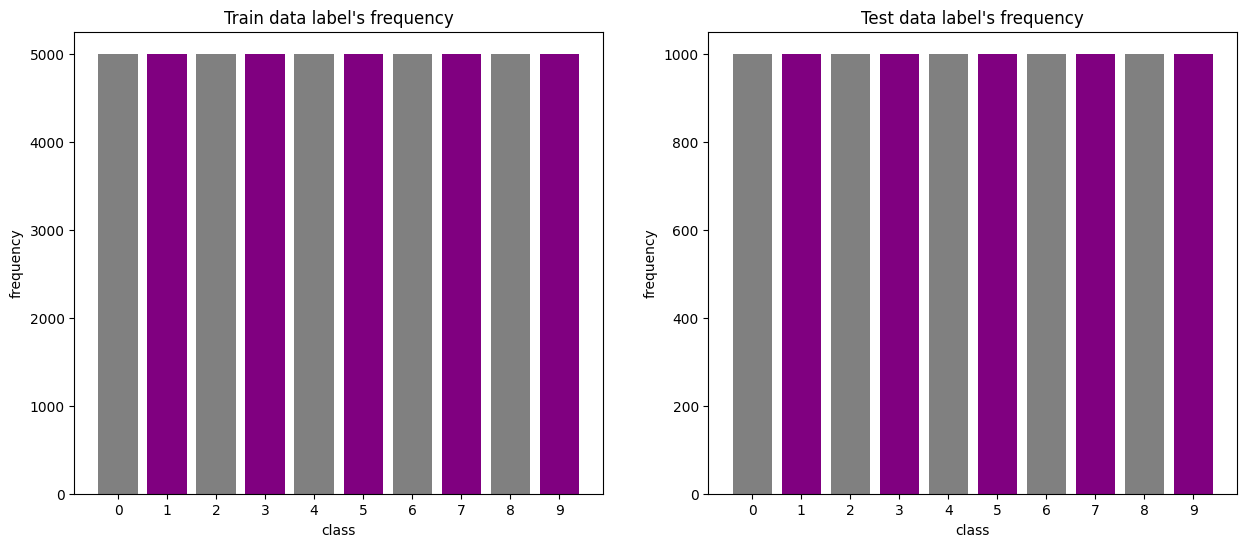

In [8]:
show_frequency(y_train, y_test)

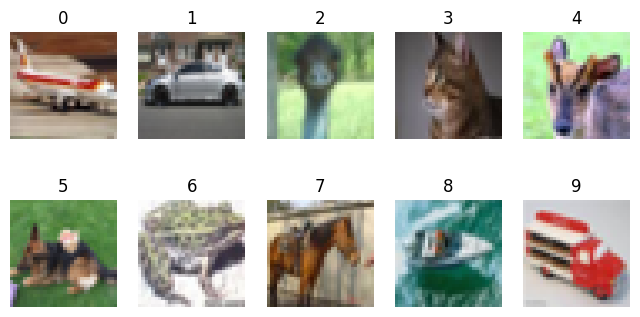

In [9]:
fig, axs = plt.subplots(2, 5,figsize=(8,4))
for i in range(10): 
    j = random.randint(0,5000)
    label = np.where(y_train == i)[0][j]
    axs[i//5,i%5].imshow(X_train[label],cmap='gray_r')
    axs[i//5,i%5].set_title(i)
    axs[i//5,i%5].axis('off')
plt.show()
    

## 2. Convolutional Neural Networks

## 2.1 Layers

- `Conv2D` Layer:
The Conv2D layer is a core layer in Keras used for convolutional neural networks (CNNs). This layer performs the convolution operation on the input image and applies filters to extract different features from it. The Conv2D layer takes the input tensor and produces an output tensor of the same shape, with a specified number of filters.

- `Activation` Layer:
The Activation layer is used to introduce non-linearity into the network. This layer applies a specific activation function element-wise to the input tensor. An activation function is a mathematical function that determines the output of a neuron given its input.

- `MaxPooling2D` Layer:
The MaxPooling2D layer is used for pooling operations in CNNs. It reduces the spatial dimensions (width and height) of the input by taking the maximum value within a certain window size. This reduces the computational load while retaining the important features of the input.

- `Flatten` Layer:
The Flatten layer is used to convert an n-dimensional input tensor into a one-dimensional tensor. This is typically done before passing the output through a fully connected layer. Flattening is necessary because densely connected layers require one-dimensional inputs.

- `Dense` Layer:
The Dense layer is the standard fully connected layer in Keras. It performs a linear operation on the input tensor followed by a non-linear activation function. The output of this layer can then be passed as input to the next layer.


## 2.2 Optimizer

`SGD` (Stochastic Gradient Descent):

- SGD is a simple and widely-used optimization algorithm that updates the weights of a neural network based on the gradient of the loss function with respect to those weights. The basic idea of SGD is to take small steps in the direction of the steepest descent of the loss function. This is done by computing the gradient of the loss function with respect to the weights for each training sample, and using this to update the weights by a small amount. The learning rate determines the size of the step taken at each iteration.

- One limitation of SGD is that it can get stuck in local minima, which are sub-optimal solutions that may not correspond to the global minimum of the loss function. To address this issue, various modifications of SGD have been proposed, such as Momentum, Adagrad, and RMSprop, which adjust the learning rate dynamically based on the history of gradients.

`Adam` (Adaptive Moment Estimation):

- Adam is a relatively new optimization algorithm that combines the benefits of several other optimization algorithms, including SGD with momentum and RMSprop. Adam uses adaptive learning rates that are based on estimates of the first and second moments of the gradients.

- The basic idea of Adam is to compute an exponentially weighted moving average of the gradients and their squares, and use these estimates to update the weights. Specifically, Adam maintains an estimate of the mean and variance of the gradient, and computes a scaled gradient that takes into account the variation of the gradient over time. This helps to prevent oscillations and overshooting, and makes Adam more robust to noisy gradients.

- Compared to SGD, Adam tends to converge faster and requires less tuning of the learning rate. However, it may be less suitable for very large datasets or high-dimensional problems, where the computational cost of computing the moving averages can become prohibitive.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Input, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam

def run_model(train, test, metrics=None, n_epochs=5, regularization=False):
    
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))

    if(regularization):
        cnn.add(BatchNormalization())

    cnn.add(Activation('relu'))
    cnn.add(Conv2D(32, (3, 3)))

    if(regularization):
        cnn.add(BatchNormalization())

    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(64, (3, 3), padding='same'))

    if(regularization):
        cnn.add(BatchNormalization())

    cnn.add(Activation('relu'))
    cnn.add(Conv2D(64, (3, 3)))

    if(regularization):
        cnn.add(BatchNormalization())

    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(512))
    cnn.add(Activation('relu'))

    if(regularization):
        cnn.add(BatchNormalization())
        cnn.add(Dropout(0.5))

    cnn.add(Dense(10))
    cnn.add(Activation('softmax'))



    cnn.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    log = cnn.fit(x=train, epochs=n_epochs, validation_data=test, callbacks=[metrics])
    clear_gpu_memory()
    return log


## 2.3 Generate Batches from Data

In [11]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
        

## 2.4 Metrics 
- `Accuracy` measures the percentage of correct predictions made by a model out of all predictions. It is calculated as the number of correct classifications divided by the total number of predictions.

- `Precision` measures the proportion of true positives (correctly identified instances of a specific class) among all positive predictions made by the model. It is calculated as the number of true positives divided by the sum of true positives and false positives.

- `Recall`, also known as sensitivity, measures the proportion of true positives identified by the model out of all actual positives in the dataset. It is calculated as the number of true positives divided by the sum of true positives and false negatives.

- `F1 score` is the harmonic mean of precision and recall, which takes into account both the precision and recall of a classifier.

$$Accuracy = \frac{total\ correctly\ detected}{total\ pictures}$$
$$Precision = \frac{correctly\ detected\ in\ class}{detected\ ones\ in\ class}$$
$$Recall = \frac{correctly\ detected\ in\ class}{total\ pictures\ in\ class}$$
$$ F1 = 2\times \frac{Precision \times Recall}{Precision + Recall}$$


In [12]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from keras.callbacks import Callback
import pandas as pd

class MetricsCallback(Callback):
    def __init__(self, x_train, y_train_true, x_test, y_test_true, avg = 'macro', show_train = False):
        super().__init__()
        self.x_train = x_train
        self.y_train_true = y_train_true
        self.x_test = x_test
        self.y_test_true = y_test_true

        self.avg = avg
        self.show_train = show_train

    def on_train_begin(self, logs=None):
        self.f1s = []
        self.recalls = []
        self.precisions = []

        cols = [*range(10),'All Classes']
        rows = ['Test Precision', 'Test Recall', 'Test F1', 'Test Avg Precision', 'Test Avg Recall', 'Test Avg F1']
        if(self.show_train):
            rows += ['Train Precision', 'Train Recall', 'Train F1', 'Train Avg Precision', 'Train Avg Recall', 'Train Avg F1']

        rows += ['-', 'Test Accuracy', 'Train Accuracy']

        self.df = pd.DataFrame(index=rows, columns=cols)
        

    def on_epoch_end(self, epoch, logs=None):
        if(self.show_train):
            y_train_pred = self.model.predict(self.x_train)
            y_train_pred = np.argmax(y_train_pred, axis=1)       

            f1_train = f1_score(self.y_train_true, y_train_pred, average=self.avg)
            recall_train = recall_score(self.y_train_true, y_train_pred, average=self.avg)
            precision_train = precision_score(self.y_train_true, y_train_pred, average=self.avg)
            f1s_train = f1_score(self.y_train_true, y_train_pred, labels=range(10), average=None)
            recalls_train = recall_score(self.y_train_true, y_train_pred, labels=range(10), average=None)
            precisions_train = precision_score(self.y_train_true, y_train_pred, labels=range(10), average=None)
            
            for i in range(10):
                self.df.loc['Train Precision', i] = precisions_train[i]
                self.df.loc['Train Recall', i] = recalls_train[i]
                self.df.loc['Train F1', i] = f1s_train[i]

            self.df.loc['Train Avg Precision', 'All Classes'] = precision_train
            self.df.loc['Train Avg Recall', 'All Classes'] = recall_train
            self.df.loc['Train Avg F1', 'All Classes'] = f1_train


        y_test_pred = self.model.predict(self.x_test)
        y_test_pred = np.argmax(y_test_pred, axis=1)

        f1_test = f1_score(self.y_test_true, y_test_pred, average=self.avg)
        recall_test = recall_score(self.y_test_true, y_test_pred, average=self.avg)
        precision_test = precision_score(self.y_test_true, y_test_pred, average=self.avg)        
        f1s_test = f1_score(self.y_test_true, y_test_pred, labels=range(10), average=None)
        recalls_test = recall_score(self.y_test_true, y_test_pred, labels=range(10), average=None)
        precisions_test = precision_score(self.y_test_true, y_test_pred, labels=range(10), average=None)
        
        cm = confusion_matrix(self.y_test_true, y_test_pred, labels=range(10))

        self.f1s.append(f1_test)
        self.recalls.append(recall_test)
        self.precisions.append(precision_test)

        for i in range(10):
            self.df.loc['Test Precision', i] = precisions_test[i]
            self.df.loc['Test Recall', i] = recalls_test[i]
            self.df.loc['Test F1', i] = f1s_test[i]
        
        self.df.loc['Test Avg Precision', 'All Classes'] = precision_test
        self.df.loc['Test Avg Recall', 'All Classes'] = recall_test
        self.df.loc['Test Avg F1', 'All Classes'] = f1_test

        self.df.loc['Test Accuracy', 'All Classes'] = logs['val_accuracy']
        self.df.loc['Train Accuracy', 'All Classes'] = logs['accuracy']


        display((self.df * 100).astype(float).round(2).fillna('-'))
        
        matrix_disp = ConfusionMatrixDisplay(cm)
        matrix_disp.plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()

    def on_train_end(self, logs=None):
        self.model.history.history['f1s'] = self.f1s
        self.model.history.history['recalls'] = self.recalls
        self.model.history.history['precisions'] = self.precisions


In [13]:
def show_plots(log):
    fig, axs = plt.subplots(2, 3,figsize=(20,12)) 
        
    axs[0,0].plot(log.history['val_loss'])
    axs[0,0].set_title('loss per epoch')
    axs[0,1].plot(log.history['accuracy'])
    axs[0,1].set_title('train accuracy per epoch')
    axs[0,2].plot(log.history['val_accuracy'])
    axs[0,2].set_title('test accuracy per epoch')

    axs[1,0].plot(log.history['recalls'])
    axs[1,0].set_title('recall per epoch')
    axs[1,1].plot(log.history['precisions'])
    axs[1,1].set_title('precision per epoch')
    axs[1,2].plot(log.history['f1s'])
    axs[1,2].set_title('f1 per epoch')

    plt.show()


## 3 Results and Analyzes

## 3.1 Running Model


In [14]:
X_train_norm= normalize_images(X_train)
X_test_norm = normalize_images(X_test)

train_gen = DataGenerator(X_train_norm, y_train_onehot, 32)
test_gen = DataGenerator(X_test_norm, y_test_onehot, 32)

Epoch 1/10
313/313 [==============================] - 1s 2ms/step loss: 1.36


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,73.99,82.66,51.49,45.41,56.43,60.05,51.99,76.44,69.5,78.75,-
Test Recall,64.0,81.5,41.5,42.0,51.8,48.1,88.7,66.2,83.4,73.0,-
Test F1,68.63,82.07,45.96,43.64,54.01,53.41,65.56,70.95,75.82,75.77,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,64.67
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,64.02
Test Avg F1,-,-,-,-,-,-,-,-,-,-,63.58
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,64.02
Train Accuracy,-,-,-,-,-,-,-,-,-,-,50.47


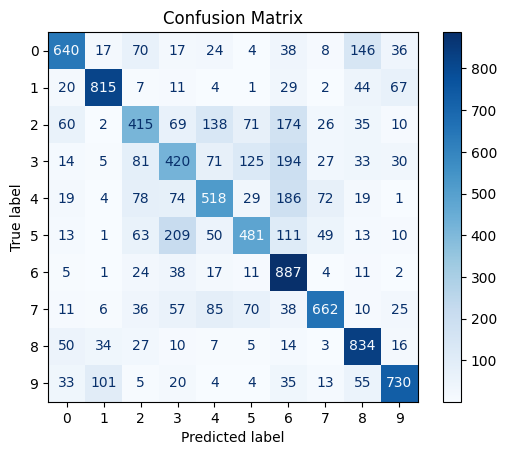

1563/1563 [==============================] - 16s 8ms/step - loss: 1.3684 - accuracy: 0.5047 - val_loss: 1.0181 - val_accuracy: 0.6402
Epoch 2/10
313/313 [==============================] - 1s 2ms/step loss: 0.8


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,66.78,77.12,58.72,49.11,73.16,53.3,87.84,75.89,80.74,87.8,-
Test Recall,79.2,89.0,61.3,52.7,53.7,69.5,62.1,74.6,83.0,69.1,-
Test F1,72.46,82.64,59.98,50.84,61.94,60.33,72.76,75.24,81.85,77.34,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.05
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,69.42
Test Avg F1,-,-,-,-,-,-,-,-,-,-,69.54
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,69.42
Train Accuracy,-,-,-,-,-,-,-,-,-,-,68.88


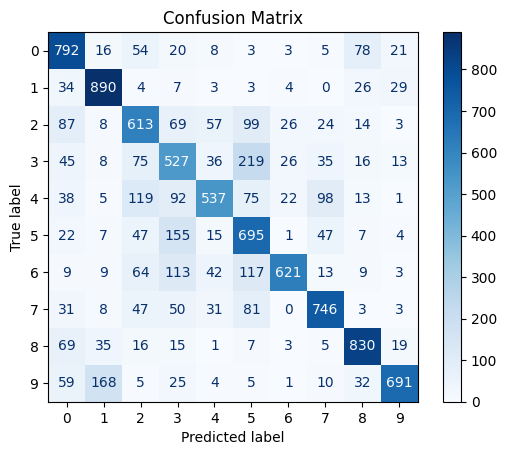

1563/1563 [==============================] - 12s 8ms/step - loss: 0.8855 - accuracy: 0.6888 - val_loss: 0.8691 - val_accuracy: 0.6942
Epoch 3/10
313/313 [==============================] - 1s 2ms/step loss: 0


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,80.42,86.69,67.62,54.44,64.27,70.19,83.75,73.17,86.67,76.62,-
Test Recall,73.5,84.0,57.0,58.9,77.7,58.4,77.8,82.1,81.9,88.5,-
Test F1,76.8,85.32,61.86,56.58,70.35,63.76,80.66,77.38,84.22,82.13,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,74.38
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,73.98
Test Avg F1,-,-,-,-,-,-,-,-,-,-,73.91
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,73.98
Train Accuracy,-,-,-,-,-,-,-,-,-,-,76.17


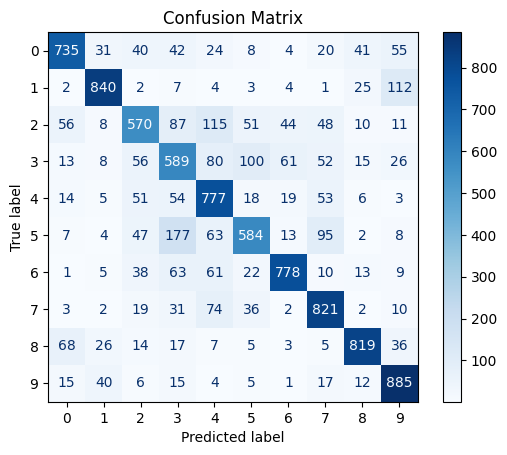

1563/1563 [==============================] - 12s 8ms/step - loss: 0.6857 - accuracy: 0.7617 - val_loss: 0.7631 - val_accuracy: 0.7398
Epoch 4/10
313/313 [==============================] - 1s 2ms/step loss: 0


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,81.04,93.97,64.36,52.32,73.51,70.02,74.63,83.25,84.05,83.69,-
Test Recall,74.8,81.0,59.4,64.2,71.6,63.3,86.2,79.5,88.0,86.2,-
Test F1,77.8,87.0,61.78,57.66,72.54,66.49,80.0,81.33,85.98,84.93,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,76.08
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.42
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.55
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.42
Train Accuracy,-,-,-,-,-,-,-,-,-,-,81.06


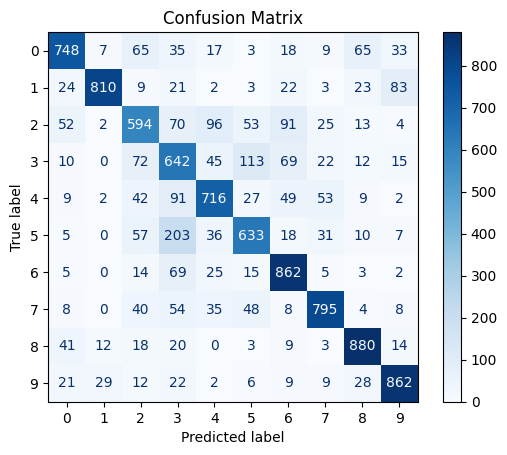

1563/1563 [==============================] - 12s 8ms/step - loss: 0.5385 - accuracy: 0.8106 - val_loss: 0.7271 - val_accuracy: 0.7542
Epoch 5/10
313/313 [==============================] - 1s 2ms/step loss: 0.4


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,80.94,84.33,68.59,51.59,72.27,61.31,84.44,77.55,92.7,88.19,-
Test Recall,77.3,89.9,63.1,66.5,70.1,66.7,77.6,80.5,78.7,79.9,-
Test F1,79.08,87.03,65.73,58.1,71.17,63.89,80.88,79.0,85.13,83.84,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,76.19
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.03
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.38
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.03
Train Accuracy,-,-,-,-,-,-,-,-,-,-,85.48


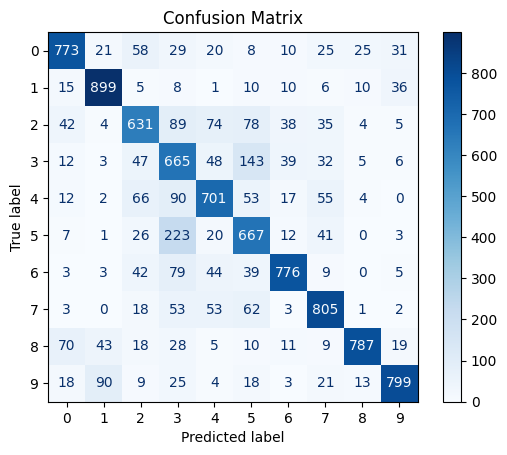

1563/1563 [==============================] - 12s 8ms/step - loss: 0.4112 - accuracy: 0.8548 - val_loss: 0.8295 - val_accuracy: 0.7503
Epoch 6/10
313/313 [==============================] - 1s 2ms/step loss: 0.2


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,76.2,84.65,61.86,57.29,73.52,59.61,82.81,78.91,91.25,89.53,-
Test Recall,81.0,89.9,61.3,53.8,69.7,74.1,79.5,80.8,81.3,78.7,-
Test F1,78.53,87.2,61.58,55.49,71.56,66.07,81.12,79.84,85.99,83.77,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,75.56
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.01
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.11
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.01
Train Accuracy,-,-,-,-,-,-,-,-,-,-,89.46


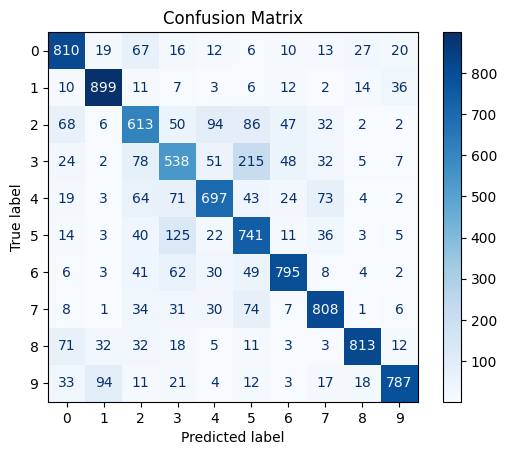

1563/1563 [==============================] - 12s 8ms/step - loss: 0.2999 - accuracy: 0.8946 - val_loss: 0.9006 - val_accuracy: 0.7501
Epoch 7/10
313/313 [==============================] - 1s 2ms/step loss: 0.2


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,78.32,87.51,62.99,50.44,64.68,75.87,86.86,86.72,88.69,83.59,-
Test Recall,79.1,87.6,66.9,63.2,80.2,56.6,78.0,73.8,83.9,83.0,-
Test F1,78.71,87.56,64.89,56.1,71.61,64.83,82.19,79.74,86.23,83.29,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,76.57
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.23
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.51
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.23
Train Accuracy,-,-,-,-,-,-,-,-,-,-,92.5


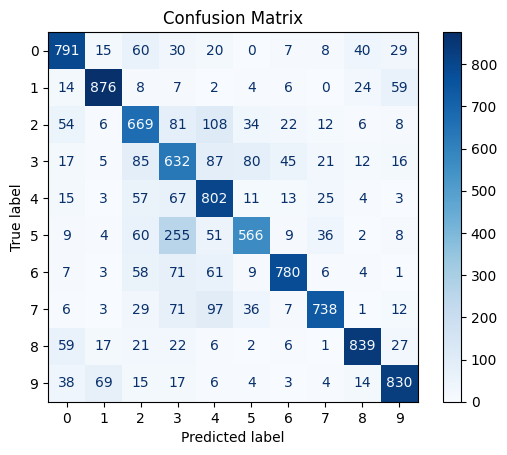

1563/1563 [==============================] - 12s 8ms/step - loss: 0.2134 - accuracy: 0.9250 - val_loss: 1.0453 - val_accuracy: 0.7523
Epoch 8/10
313/313 [==============================] - 1s 2ms/step loss: 0


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,75.37,83.52,67.58,55.92,73.07,66.24,81.41,77.49,85.86,84.99,-
Test Recall,81.7,91.2,61.5,53.4,70.0,67.1,77.5,82.6,85.6,82.7,-
Test F1,78.41,87.19,64.4,54.63,71.5,66.67,79.41,79.96,85.73,83.83,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,75.14
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.33
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.17
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.33
Train Accuracy,-,-,-,-,-,-,-,-,-,-,94.42


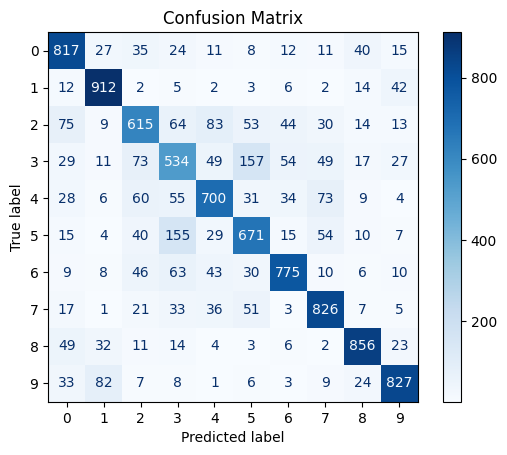

1563/1563 [==============================] - 12s 8ms/step - loss: 0.1599 - accuracy: 0.9442 - val_loss: 1.0717 - val_accuracy: 0.7533
Epoch 9/10
313/313 [==============================] - 1s 2ms/step loss: 0


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,79.48,81.61,66.81,56.91,74.54,62.95,74.98,79.32,85.84,89.53,-
Test Recall,77.1,91.0,61.6,56.4,68.5,67.8,84.2,79.4,86.1,78.7,-
Test F1,78.27,86.05,64.1,56.65,71.39,65.29,79.32,79.36,85.97,83.77,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,75.2
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,75.08
Test Avg F1,-,-,-,-,-,-,-,-,-,-,75.02
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,75.08
Train Accuracy,-,-,-,-,-,-,-,-,-,-,95.2


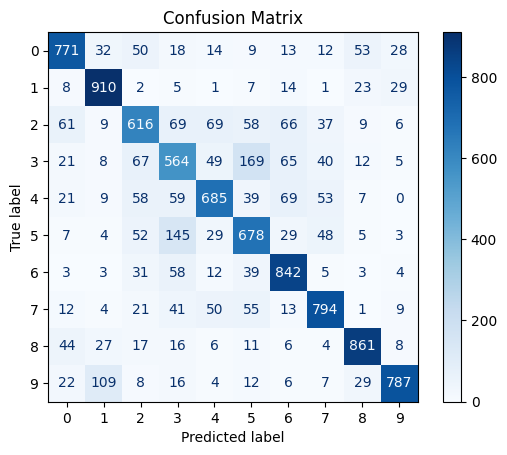

1563/1563 [==============================] - 12s 8ms/step - loss: 0.1389 - accuracy: 0.9520 - val_loss: 1.2210 - val_accuracy: 0.7508
Epoch 10/10
313/313 [==============================] - 1s 2ms/step loss: 0.1


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,79.26,89.12,65.33,56.21,66.75,64.67,76.97,81.55,82.44,85.61,-
Test Recall,74.5,86.8,63.5,50.7,75.9,68.1,81.2,76.9,87.8,82.1,-
Test F1,76.8,87.94,64.4,53.31,71.03,66.34,79.03,79.16,85.04,83.82,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,74.79
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,74.75
Test Avg F1,-,-,-,-,-,-,-,-,-,-,74.69
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,74.75
Train Accuracy,-,-,-,-,-,-,-,-,-,-,95.99


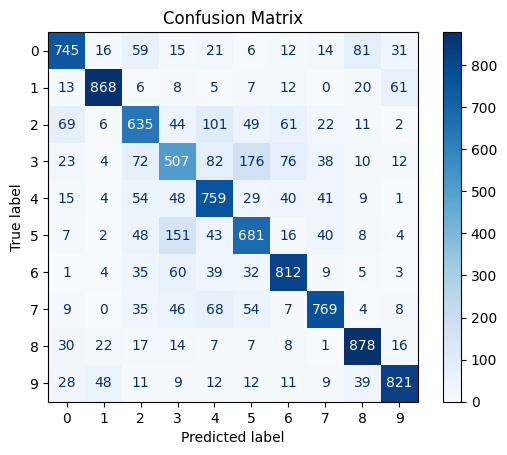

1563/1563 [==============================] - 12s 8ms/step - loss: 0.1165 - accuracy: 0.9599 - val_loss: 1.4408 - val_accuracy: 0.7475


In [15]:
metrics = MetricsCallback(
    x_train = X_train_norm,
    y_train_true = y_train,
    x_test = X_test_norm, 
    y_test_true = y_test,
    avg = 'macro',
    show_train = False
)


log = run_model(
    train = train_gen,
    test = test_gen,
    metrics = metrics,
    n_epochs = 10,
    regularization = False
)

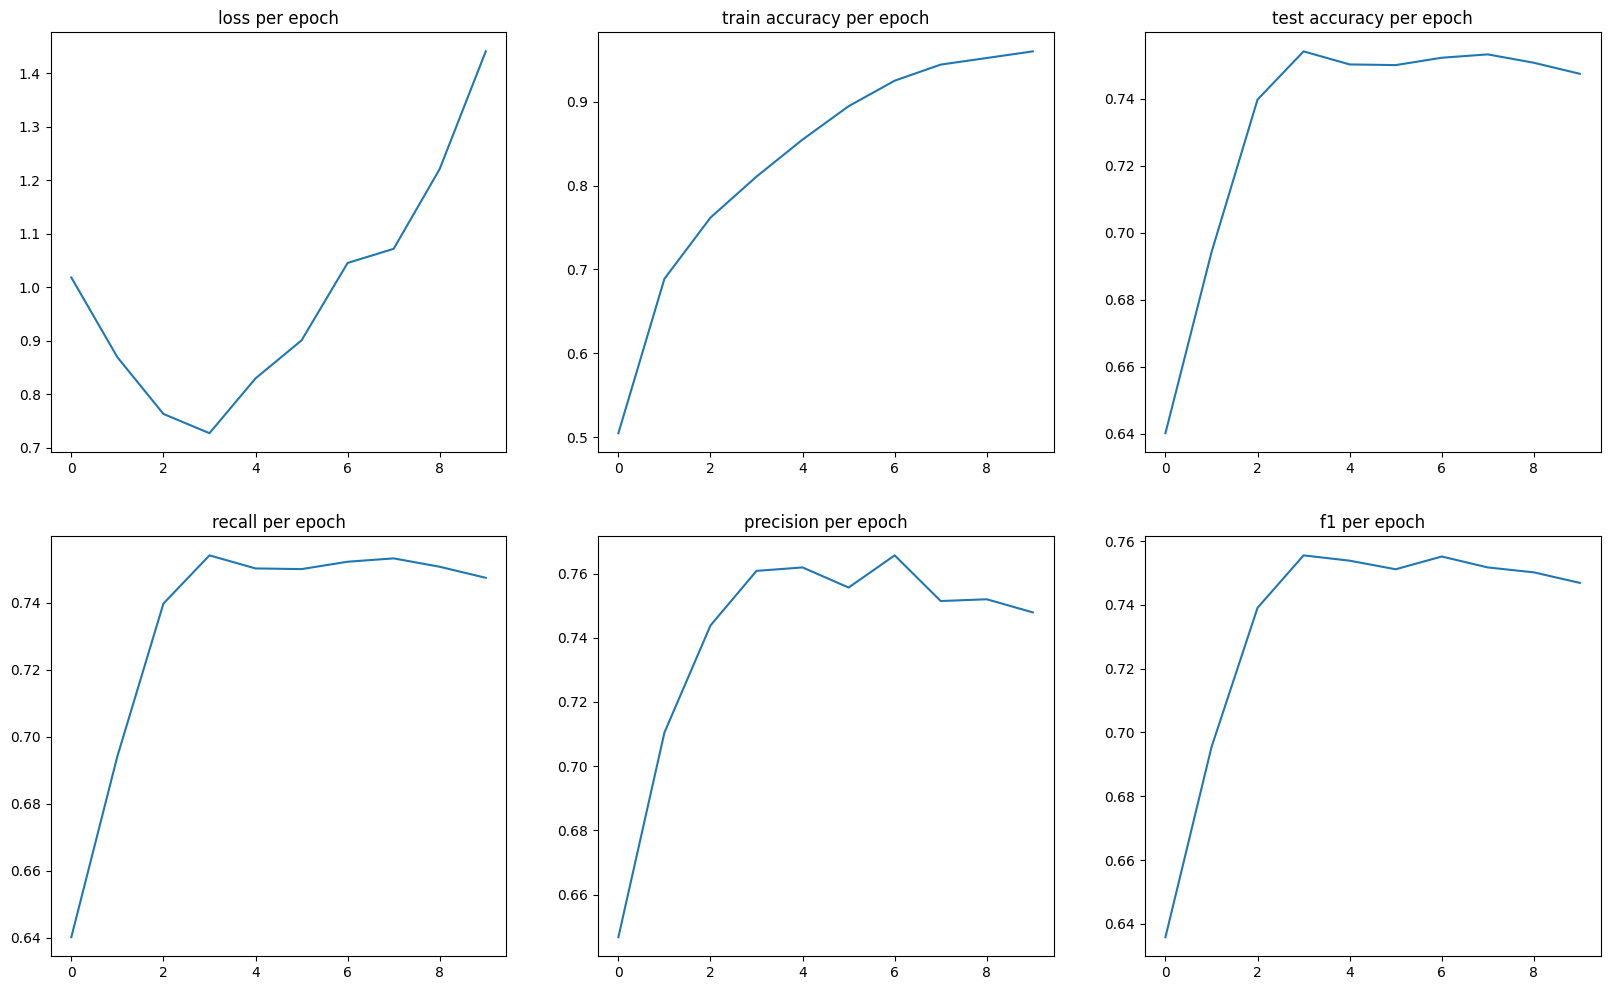

In [16]:
show_plots(log)

## 3.2 Unbalanced Data


In [17]:
def remove_data(X, Y, labels: list, removal_percentage):
    to_del = []
    for label in labels:
        indexes = list(np.where(Y == label)[0])
        to_del += random.sample(indexes, k = int(len(indexes) * removal_percentage))
        
    newY = np.delete(Y, to_del, axis=0)
    newX = np.delete(X, to_del, axis=0)

    return newX, newY


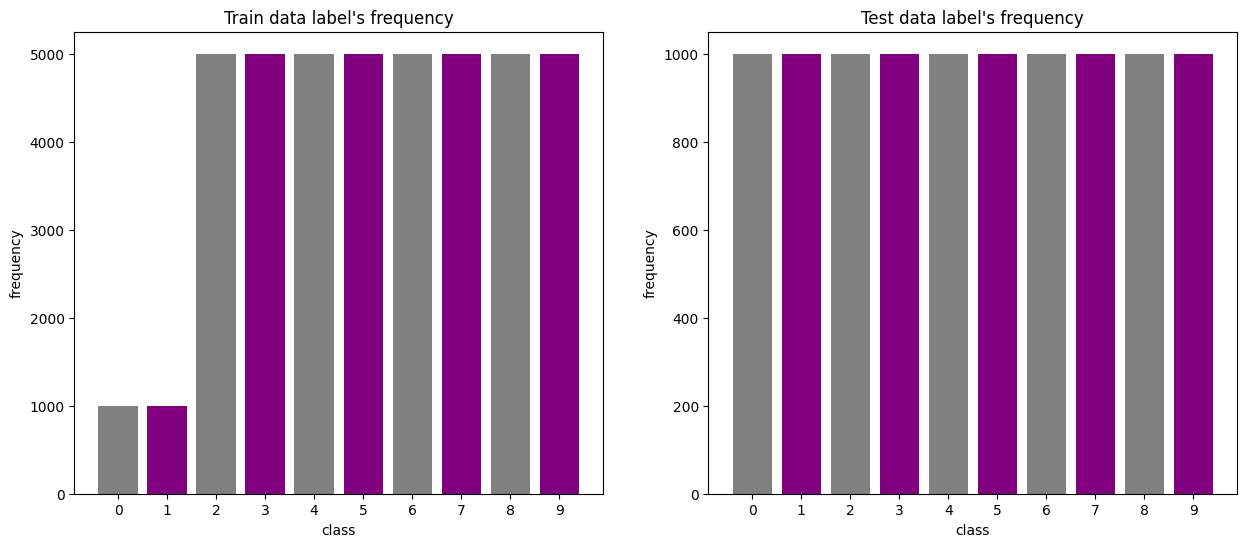

In [18]:
unbalanced_X, unbalanced_y = remove_data(X_train, y_train, labels=[0,1], removal_percentage=0.8)
show_frequency(unbalanced_y, y_test)

In [19]:
unbalanced_y_onehot = to_categorical(unbalanced_y)

unbalanced_X_norm  = normalize_images(unbalanced_X)

unbalanced_train_gen = DataGenerator(unbalanced_X_norm, unbalanced_y_onehot, 32)


- Training on unbalanced data can have a significant impact on accuracy, precision, recall, and F1 score.

- Accuracy alone is not a reliable metric when it comes to evaluating the performance of a model trained on an unbalanced dataset. In such cases, precision, recall, and F1 score are more commonly used.

- Precision measures how many of the predicted positive instances are truly positive, while recall measures how many of the actual positive instances are identified by the model. F1 score provides a balance between precision and recall.

- When training on an unbalanced dataset, the precision of the model may be high for the majority class, but low for the minority class, leading to a low overall F1 score. Similarly, the recall of the model may be high for the majority class, but low for the minority class, leading to an imbalanced F1 score.

Epoch 1/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,76.02,82.97,42.85,44.72,68.25,49.29,71.55,73.88,44.29,51.27,-
Test Recall,27.9,42.4,55.1,28.4,30.1,62.2,68.4,62.5,93.8,80.9,-
Test F1,40.82,56.12,48.21,34.74,41.78,55.0,69.94,67.71,60.17,62.76,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,60.51
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,55.17
Test Avg F1,-,-,-,-,-,-,-,-,-,-,53.72
Train Precision,44.51,56.09,48.77,51.42,75.01,51.02,73.98,75.64,59.79,68.37,-
Train Recall,30.4,48.8,56.98,31.86,35.78,63.68,68.68,63.08,93.64,85.3,-
Train F1,36.13,52.19,52.55,39.34,48.45,56.65,71.23,68.79,72.98,75.9,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,62.39


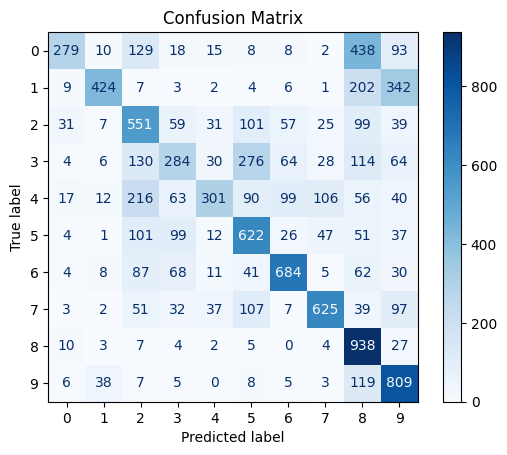

1313/1313 [==============================] - 15s 11ms/step - loss: 1.3772 - accuracy: 0.5036 - val_loss: 1.2180 - val_accuracy: 0.5517
Epoch 2/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,88.36,85.84,53.48,46.37,67.75,67.1,74.42,68.23,61.01,70.56,-
Test Recall,25.8,66.1,61.5,58.7,54.2,56.9,79.7,78.8,88.4,84.6,-
Test F1,39.94,74.69,57.21,51.81,60.22,61.58,76.97,73.13,72.19,76.94,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,68.31
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,65.47
Test Avg F1,-,-,-,-,-,-,-,-,-,-,64.47
Train Precision,76.99,68.58,65.21,54.3,77.13,71.74,79.26,74.96,84.4,88.61,-
Train Recall,35.8,75.1,69.16,63.98,62.24,59.4,80.56,83.56,91.2,88.82,-
Train F1,48.87,71.69,67.13,58.75,68.89,64.99,79.9,79.02,87.67,88.71,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,74.37


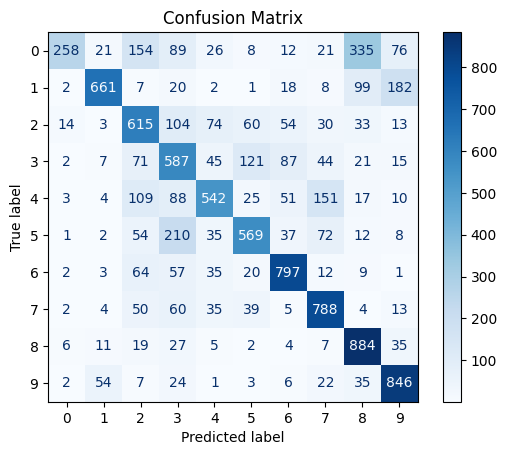

1313/1313 [==============================] - 14s 10ms/step - loss: 0.9524 - accuracy: 0.6637 - val_loss: 0.9767 - val_accuracy: 0.6547
Epoch 3/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,86.51,86.0,50.07,51.56,71.95,68.99,85.11,84.19,55.79,80.12,-
Test Recall,40.4,73.7,69.9,57.9,60.8,59.4,74.9,71.9,94.9,81.4,-
Test F1,55.08,79.38,58.35,54.55,65.91,63.84,79.68,77.56,70.27,80.75,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.03
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,68.52
Test Avg F1,-,-,-,-,-,-,-,-,-,-,68.54
Train Precision,76.69,71.32,63.86,63.33,81.79,77.79,91.01,91.41,77.1,94.92,-
Train Recall,52.3,84.8,81.14,70.4,71.76,65.0,79.76,80.02,97.58,86.68,-
Train F1,62.19,77.48,71.47,66.68,76.45,70.82,85.01,85.34,86.14,90.61,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,79.86


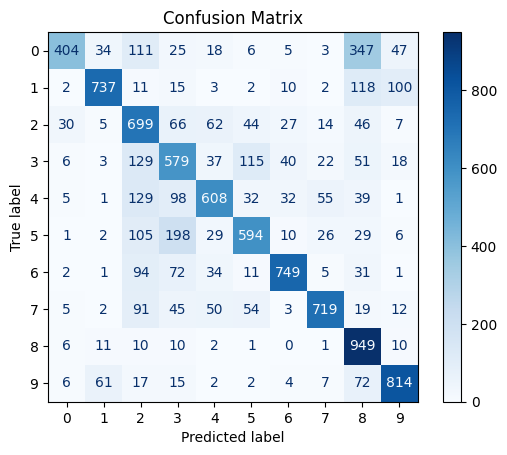

1313/1313 [==============================] - 13s 10ms/step - loss: 0.7541 - accuracy: 0.7343 - val_loss: 0.9039 - val_accuracy: 0.6852
Epoch 4/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,89.44,96.37,53.23,57.19,64.74,65.65,78.21,79.94,70.78,70.39,-
Test Recall,39.8,53.1,70.1,54.5,74.9,66.7,82.2,78.1,91.1,87.7,-
Test F1,55.09,68.47,60.51,55.81,69.45,66.17,80.16,79.01,79.67,78.09,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.59
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,69.82
Test Avg F1,-,-,-,-,-,-,-,-,-,-,69.24
Train Precision,89.63,97.31,77.42,77.46,80.61,79.17,88.99,92.79,92.58,94.29,-
Train Recall,62.2,72.3,85.86,71.68,87.72,79.52,89.84,87.28,96.02,94.12,-
Train F1,73.44,82.96,81.42,74.46,84.01,79.35,89.41,89.95,94.27,94.2,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,85.8


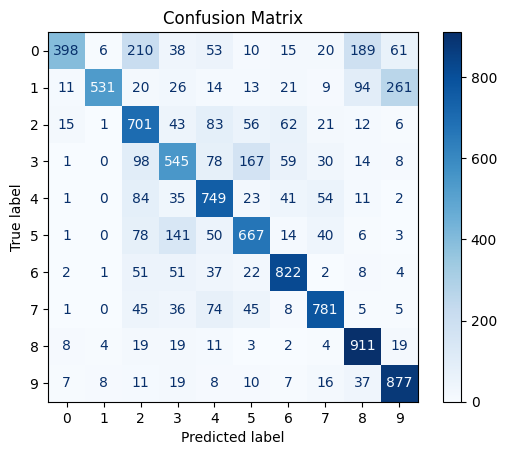

1313/1313 [==============================] - 13s 10ms/step - loss: 0.5986 - accuracy: 0.7918 - val_loss: 0.8955 - val_accuracy: 0.6982
Epoch 5/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,92.81,93.53,56.03,50.95,66.86,57.07,78.01,71.73,81.32,63.59,-
Test Recall,29.7,50.6,66.4,53.9,69.2,73.9,83.0,80.7,81.4,87.5,-
Test F1,45.0,65.67,60.78,52.38,68.01,64.4,80.43,75.95,81.36,73.65,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.19
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,67.63
Test Avg F1,-,-,-,-,-,-,-,-,-,-,66.76
Train Precision,94.27,98.33,85.74,79.37,87.74,78.32,90.51,90.97,98.52,92.85,-
Train Recall,54.3,76.4,86.12,78.96,87.3,90.34,91.58,94.04,89.36,95.56,-
Train F1,68.91,85.99,85.93,79.17,87.52,83.9,91.04,92.48,93.72,94.18,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,88.4


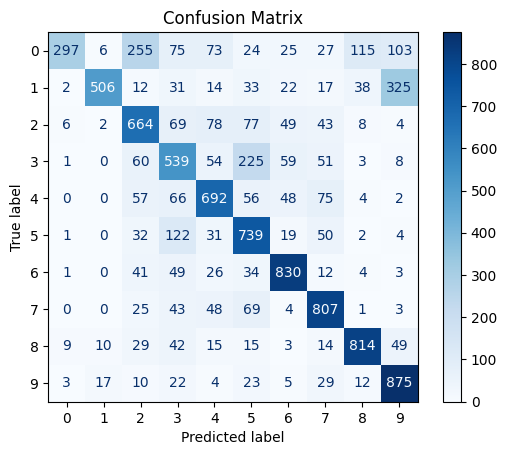

1313/1313 [==============================] - 14s 10ms/step - loss: 0.4620 - accuracy: 0.8375 - val_loss: 1.1168 - val_accuracy: 0.6763
Epoch 6/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,85.04,89.53,65.27,53.39,69.67,67.16,78.59,79.3,69.31,68.03,-
Test Recall,50.6,68.4,60.7,61.5,68.9,63.4,80.4,78.9,91.0,88.1,-
Test F1,63.45,77.55,62.9,57.16,69.28,65.23,79.49,79.1,78.69,76.78,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.53
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.19
Test Avg F1,-,-,-,-,-,-,-,-,-,-,70.96
Train Precision,90.36,92.52,94.25,84.92,93.41,91.69,93.85,95.25,95.08,95.24,-
Train Recall,89.0,95.3,87.16,89.12,91.82,88.06,94.32,95.88,98.64,98.14,-
Train F1,89.67,93.89,90.57,86.97,92.61,89.84,94.08,95.56,96.83,96.67,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,92.89


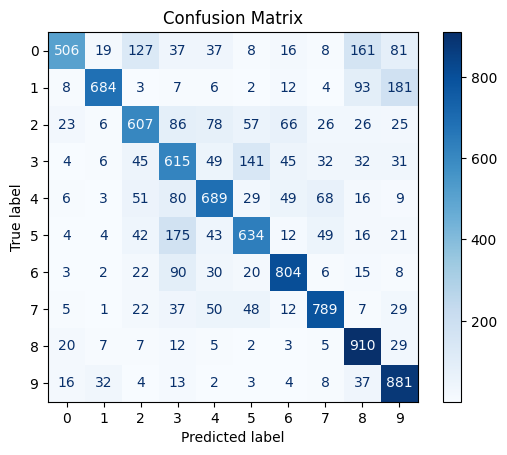

1313/1313 [==============================] - 14s 10ms/step - loss: 0.3337 - accuracy: 0.8804 - val_loss: 1.0266 - val_accuracy: 0.7119
Epoch 7/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,89.2,91.97,64.01,51.5,64.94,63.58,67.25,78.75,74.4,72.77,-
Test Recall,44.6,63.0,61.0,53.3,75.0,66.5,88.7,75.6,87.2,85.5,-
Test F1,59.47,74.78,62.47,52.38,69.61,65.0,76.5,77.14,80.29,78.62,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.84
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,70.04
Test Avg F1,-,-,-,-,-,-,-,-,-,-,69.63
Train Precision,96.61,97.81,96.48,91.95,89.15,93.14,88.87,97.94,98.11,98.93,-
Train Recall,85.4,93.7,90.44,89.08,96.34,93.68,98.52,95.2,96.62,96.32,-
Train F1,90.66,95.71,93.36,90.49,92.61,93.41,93.45,96.55,97.36,97.61,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,94.46


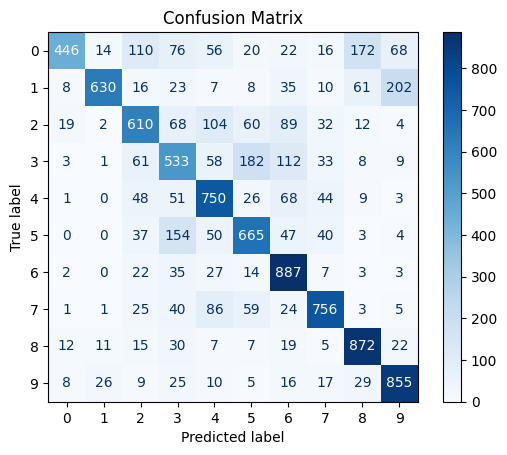

1313/1313 [==============================] - 14s 10ms/step - loss: 0.2349 - accuracy: 0.9166 - val_loss: 1.2944 - val_accuracy: 0.7004
Epoch 8/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,82.56,92.97,59.85,51.72,67.27,69.44,79.63,79.25,66.38,68.92,-
Test Recall,48.3,62.2,63.5,60.2,70.7,59.3,77.8,78.3,91.4,87.8,-
Test F1,60.95,74.54,61.62,55.64,68.94,63.97,78.71,78.77,76.9,77.22,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.8
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,69.95
Test Avg F1,-,-,-,-,-,-,-,-,-,-,69.73
Train Precision,95.64,97.8,96.65,91.79,95.31,97.55,97.98,98.7,95.28,98.37,-
Train Recall,94.3,93.3,95.18,95.88,96.76,92.52,96.1,97.42,99.78,98.76,-
Train F1,94.96,95.5,95.91,93.79,96.03,94.97,97.03,98.06,97.48,98.56,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,96.47


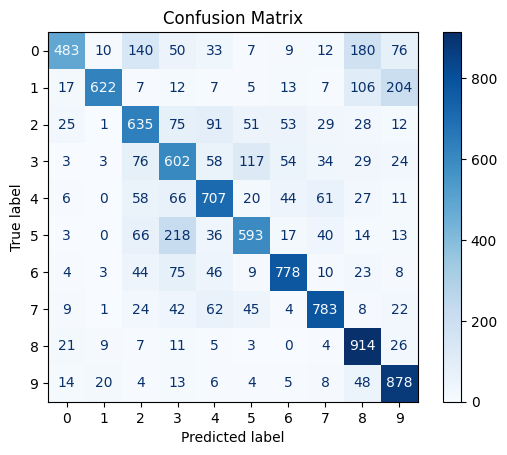

1313/1313 [==============================] - 14s 10ms/step - loss: 0.1735 - accuracy: 0.9402 - val_loss: 1.3966 - val_accuracy: 0.6995
Epoch 9/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,84.11,91.4,55.87,50.38,69.27,59.01,86.24,76.66,75.39,67.8,-
Test Recall,52.4,62.7,66.1,59.5,62.2,64.5,70.8,79.5,87.3,89.5,-
Test F1,64.57,74.38,60.56,54.56,65.54,61.63,77.76,78.06,80.91,77.16,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.61
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,69.45
Test Avg F1,-,-,-,-,-,-,-,-,-,-,69.51
Train Precision,94.84,98.55,94.32,92.23,97.37,94.42,99.54,97.59,99.22,97.78,-
Train Recall,97.4,95.3,96.92,96.86,94.16,96.76,91.08,98.18,98.64,99.38,-
Train F1,96.1,96.9,95.6,94.49,95.74,95.57,95.12,97.89,98.93,98.57,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,96.56


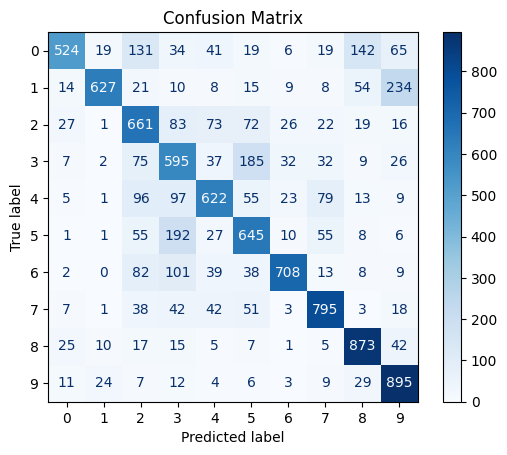

1313/1313 [==============================] - 14s 10ms/step - loss: 0.1397 - accuracy: 0.9510 - val_loss: 1.4821 - val_accuracy: 0.6945
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,80.44,87.28,60.6,53.01,69.5,64.02,82.81,77.82,69.99,69.9,-
Test Recall,55.1,70.7,66.3,57.3,66.3,63.7,74.2,76.5,88.4,86.6,-
Test F1,65.4,78.12,63.32,55.07,67.86,63.86,78.27,77.16,78.13,77.36,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.54
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,70.51
Test Avg F1,-,-,-,-,-,-,-,-,-,-,70.45
Train Precision,89.94,95.82,97.19,94.46,97.62,96.96,99.23,97.79,98.17,98.23,-
Train Recall,97.5,98.5,96.92,96.52,96.1,96.44,95.98,97.48,98.92,99.02,-
Train F1,93.57,97.14,97.06,95.48,96.86,96.7,97.58,97.64,98.55,98.63,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,97.24


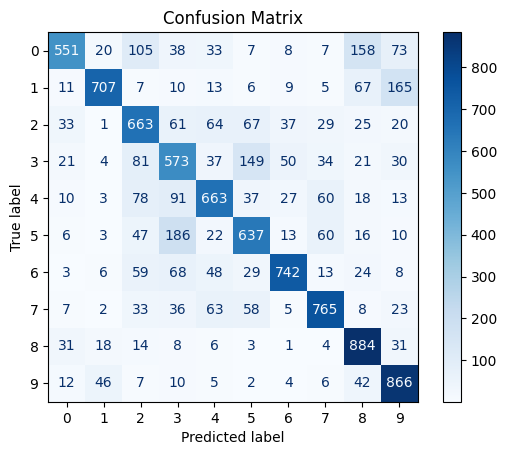

1313/1313 [==============================] - 14s 10ms/step - loss: 0.1155 - accuracy: 0.9609 - val_loss: 1.6567 - val_accuracy: 0.7051


In [20]:

metrics = MetricsCallback(
    x_train = unbalanced_X_norm,
    y_train_true = unbalanced_y,
    x_test = X_test_norm, 
    y_test_true = y_test,
    avg = 'weighted',
    show_train = True
)

log_unbalanced = run_model(
    train = unbalanced_train_gen,
    test = test_gen,
    metrics = metrics,
    n_epochs = 10,
    regularization = False,
)

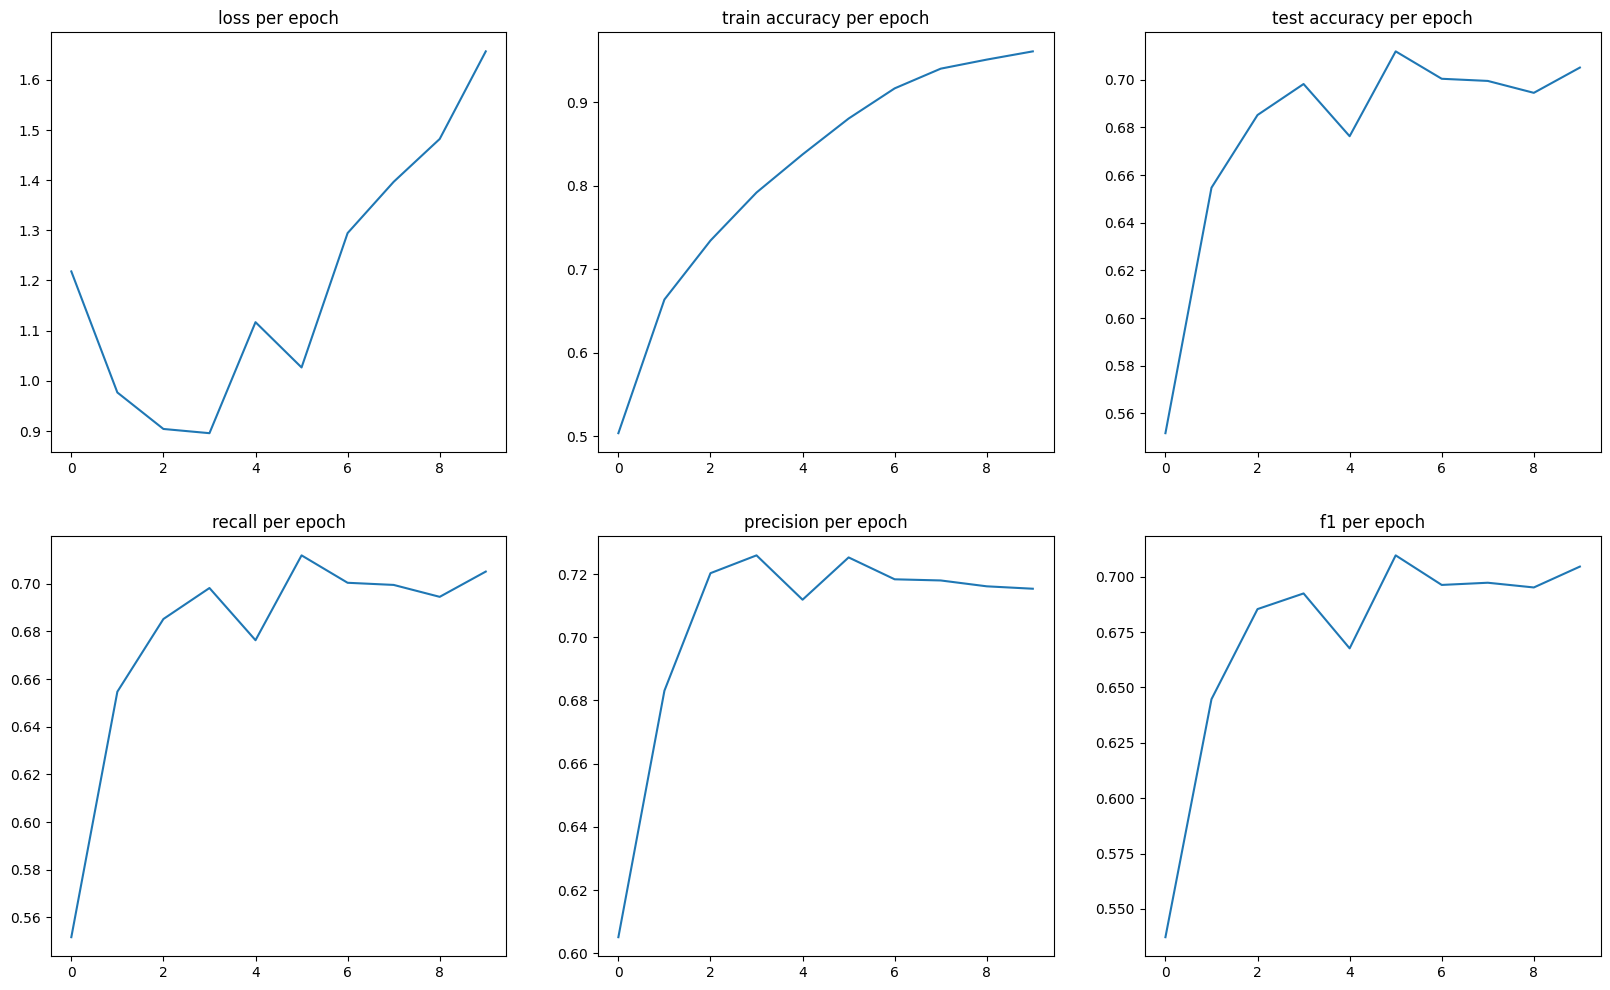

In [21]:
show_plots(log_unbalanced)

## 3.3 Data Augmentation

- Data augmentation is a technique used in machine learning and computer vision to increase the amount of training data available for a model. The goal of data augmentation is to improve the performance and robustness of a model by artificially expanding the dataset with modified versions of the original data.

- In data augmentation, new data is generated by applying various transformations to the existing data such as rotation, translation, flipping, zooming, cropping, and adding noise. These transformed images are then added to the training dataset to create a larger and more diverse set of examples for the model to learn from.

- By using data augmentation, we can prevent overfitting, i.e., where the model learns the training data too well, but performs poorly on unseen data. With data augmentation, the model sees more diverse examples during training, making it better at generalizing to new examples.

- Data augmentation is widely used in image classification, object detection, and segmentation tasks, where large amounts of labeled images are required for training deep neural networks.

image augmentation methods in Keras:
- `Rotation`: Rotates the image by a certain degree.
- `Width/Height Shift`: Shifts the image horizontally or vertically by a certain percentage.
- `Shear Transformation`: Applies shear transformation to the image.
- `Zoom`: Zooms into the image by a certain factor.
- `Channel Shift`: Shifts the color channels of the image.
- `Flip(Horizontal and Vertical)`: Flips the image horizontally or vertically.
- `Brightness`: Adjusts the brightness of the image.
- `Contrast`: Adjusts the contrast of the image.
- `Gaussian Noise`: Adds Gaussian noise to the image.
- `Coarse Dropout`: Randomly drops out rectangular regions from the image.
- `Random Erasing`: Randomly erases rectangular regions from the image.
- `Cutout`: Randomly removes square patches from the image.

In [22]:
from keras.preprocessing.image import ImageDataGenerator

Augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]
)


In [23]:
def data_augmentation(X, y, batch_size = 32, n_aug = 100, labels = []):
    
    n = X.shape[0]
    for label in labels:
        aug_target = X[(np.where(y == label)[0])]
        datagen = Augmenter.flow(aug_target, batch_size=batch_size)

        for i in range(n_aug//batch_size):
            gen = datagen.next()
            X = np.concatenate((X, gen), axis=0)

        n += n_aug

        new_labels = np.full((n_aug ,1), label)
        y = np.concatenate((y, new_labels), axis=0)

        permutation = np.random.permutation(n)
        X = X[permutation]
        y = y[permutation]

    return X.astype('int'), y


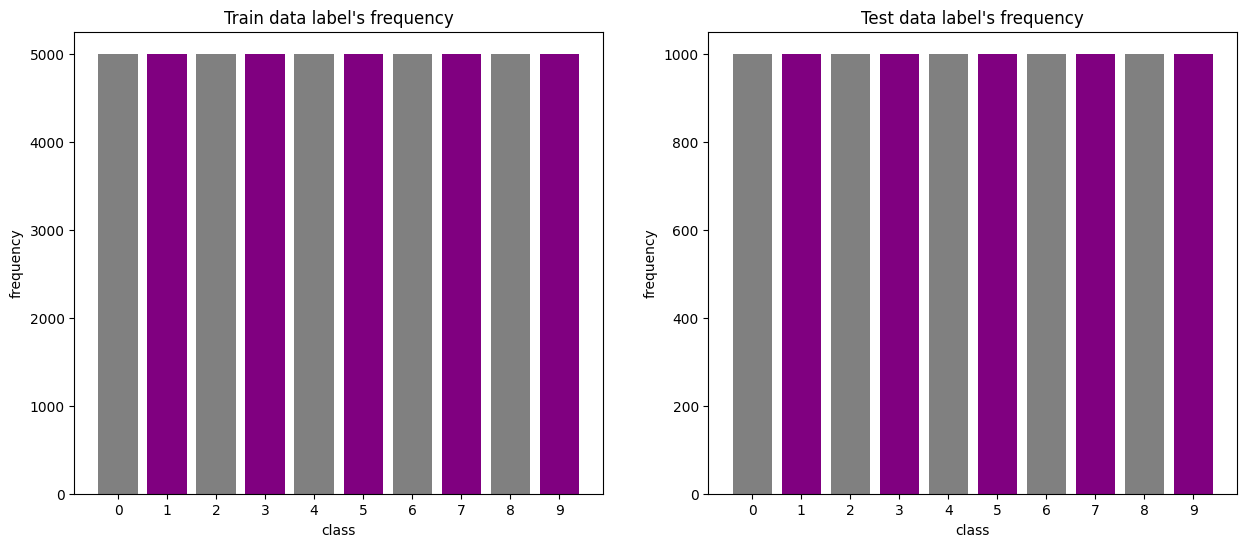

In [24]:
aug_X, aug_y = data_augmentation(
    X = unbalanced_X,
    y = unbalanced_y,
    batch_size = 40,
    n_aug = 4000,
    labels = [0,1]
)
show_frequency(aug_y, y_test)

In [25]:
aug_y_onehot = to_categorical(aug_y)

aug_X_norm = normalize_images(aug_X)

aug_train_gen = DataGenerator(aug_X_norm, aug_y_onehot, 32)



Epoch 1/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,51.83,66.04,53.33,44.03,63.34,52.36,55.51,75.87,82.09,74.79,-
Test Recall,77.9,70.0,46.4,41.3,44.4,53.3,84.1,63.2,58.2,63.8,-
Test F1,62.25,67.96,49.63,42.62,52.2,52.82,66.88,68.96,68.11,68.86,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,61.92
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,60.26
Test Avg F1,-,-,-,-,-,-,-,-,-,-,60.03
Train Precision,48.79,64.98,55.11,45.19,64.56,52.44,57.73,79.94,88.31,87.47,-
Train Recall,86.46,63.86,44.74,44.96,48.92,52.48,84.58,62.88,58.3,67.14,-
Train F1,62.38,64.41,49.39,45.07,55.66,52.46,68.62,70.39,70.23,75.97,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,64.45


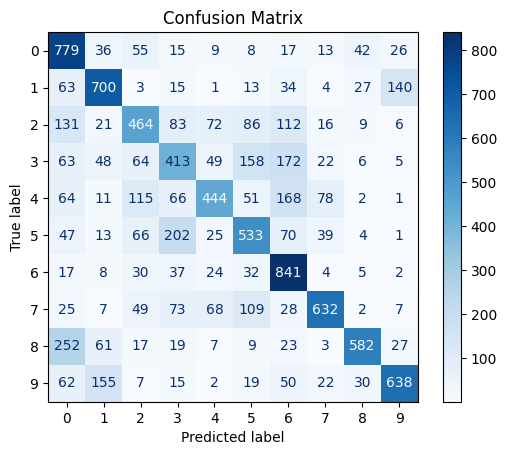

1563/1563 [==============================] - 17s 11ms/step - loss: 1.4107 - accuracy: 0.4923 - val_loss: 1.1325 - val_accuracy: 0.6026
Epoch 2/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,71.55,86.49,65.17,49.18,53.97,60.32,78.34,69.25,84.03,72.79,-
Test Recall,67.4,60.2,52.4,54.2,75.5,60.5,78.5,75.9,74.2,78.1,-
Test F1,69.41,70.99,58.09,51.57,62.94,60.41,78.42,72.42,78.81,75.35,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,69.11
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,67.69
Test Avg F1,-,-,-,-,-,-,-,-,-,-,67.84
Train Precision,70.35,89.58,70.74,53.53,58.13,62.73,81.46,73.65,92.0,90.57,-
Train Recall,80.5,67.88,56.76,59.54,80.62,63.78,80.74,79.5,75.66,80.32,-
Train F1,75.09,77.23,62.98,56.38,67.55,63.25,81.1,76.46,83.03,85.14,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,74.27


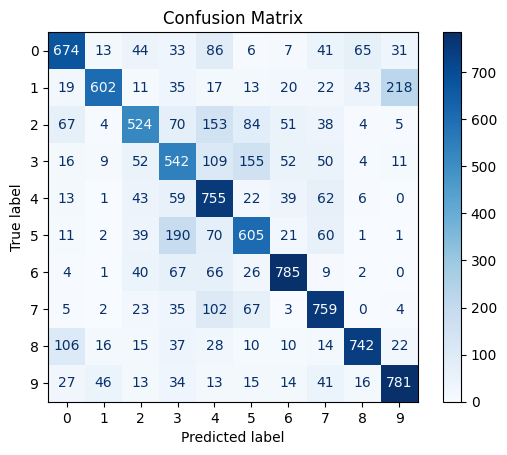

1563/1563 [==============================] - 15s 10ms/step - loss: 0.9377 - accuracy: 0.6709 - val_loss: 0.9495 - val_accuracy: 0.6769
Epoch 3/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,76.34,79.87,59.32,58.18,63.22,60.46,77.12,80.6,82.39,79.64,-
Test Recall,61.3,76.2,64.9,48.7,74.6,71.1,79.2,74.8,81.9,80.2,-
Test F1,68.0,77.99,61.99,53.02,68.44,65.35,78.15,77.59,82.15,79.92,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.72
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.29
Test Avg F1,-,-,-,-,-,-,-,-,-,-,71.26
Train Precision,83.98,84.79,71.06,65.02,70.61,65.02,85.92,87.82,93.25,94.91,-
Train Recall,79.78,88.64,74.02,56.96,83.96,75.52,83.46,81.18,87.1,86.06,-
Train F1,81.83,86.67,72.51,60.72,76.71,69.88,84.67,84.37,90.07,90.27,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,80.24


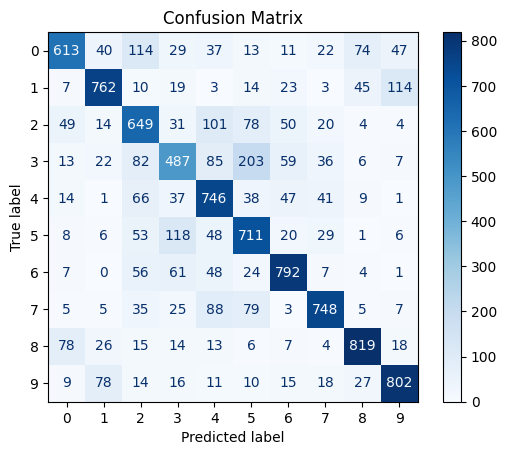

1563/1563 [==============================] - 16s 10ms/step - loss: 0.7441 - accuracy: 0.7403 - val_loss: 0.8429 - val_accuracy: 0.7129
Epoch 4/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,78.53,91.64,59.46,56.01,67.28,66.87,79.24,72.46,75.43,81.06,-
Test Recall,58.9,70.2,63.8,53.1,76.5,65.8,81.7,84.2,88.4,79.2,-
Test F1,67.31,79.5,61.55,54.52,71.6,66.33,80.45,77.89,81.4,80.12,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.8
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,72.18
Test Avg F1,-,-,-,-,-,-,-,-,-,-,72.07
Train Precision,88.52,95.6,80.86,72.29,78.39,79.07,88.83,82.56,89.8,97.08,-
Train Recall,86.2,85.1,80.08,70.54,88.06,75.64,90.38,91.54,95.24,87.66,-
Train F1,87.34,90.04,80.47,71.4,82.94,77.32,89.6,86.82,92.44,92.13,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,85.3


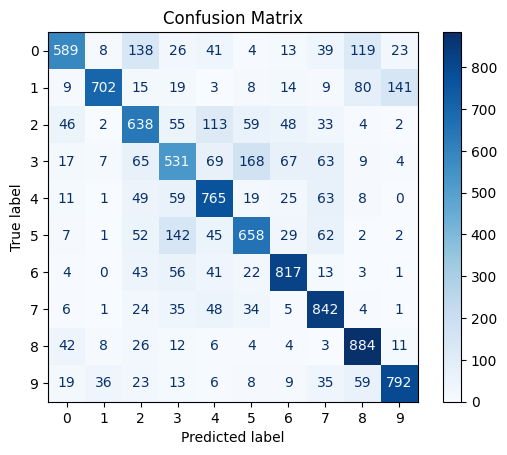

1563/1563 [==============================] - 15s 10ms/step - loss: 0.6023 - accuracy: 0.7891 - val_loss: 0.8176 - val_accuracy: 0.7218
Epoch 5/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,67.87,82.09,61.93,53.08,76.41,70.0,82.03,79.42,69.51,77.14,-
Test Recall,65.7,72.4,65.4,56.0,63.8,60.2,79.9,79.1,88.7,84.7,-
Test F1,66.77,76.94,63.62,54.5,69.54,64.73,80.95,79.26,77.94,80.74,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.95
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.59
Test Avg F1,-,-,-,-,-,-,-,-,-,-,71.5
Train Precision,81.9,93.69,82.55,75.14,91.39,87.5,92.27,93.23,86.99,95.8,-
Train Recall,91.42,90.86,84.58,80.2,81.48,76.32,89.94,91.18,97.32,94.52,-
Train F1,86.4,92.25,83.55,77.59,86.15,81.53,91.09,92.19,91.86,95.16,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,88.05


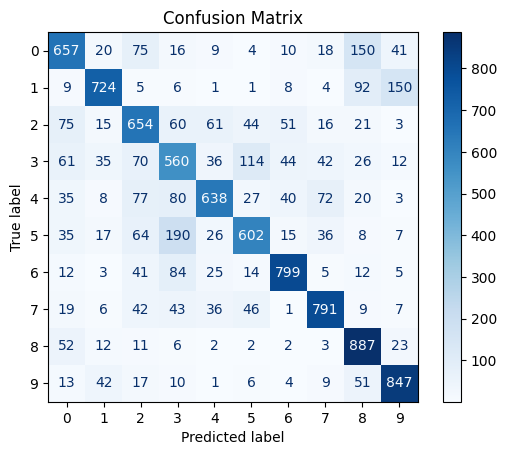

1563/1563 [==============================] - 16s 10ms/step - loss: 0.4765 - accuracy: 0.8327 - val_loss: 0.9016 - val_accuracy: 0.7159
Epoch 6/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,78.6,93.2,70.13,59.18,59.99,66.77,71.79,79.38,79.1,74.34,-
Test Recall,62.8,63.0,58.0,50.3,81.1,65.9,86.8,79.7,88.2,87.8,-
Test F1,69.82,75.18,63.49,54.38,68.96,66.33,78.59,79.54,83.4,80.51,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,73.25
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,72.36
Test Avg F1,-,-,-,-,-,-,-,-,-,-,72.02
Train Precision,90.33,99.6,93.59,86.11,79.22,88.2,87.37,94.34,95.25,95.89,-
Train Recall,92.46,84.36,82.94,79.94,95.84,84.76,97.0,95.08,96.96,96.66,-
Train F1,91.38,91.35,87.94,82.91,86.74,86.45,91.93,94.71,96.1,96.27,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,90.99


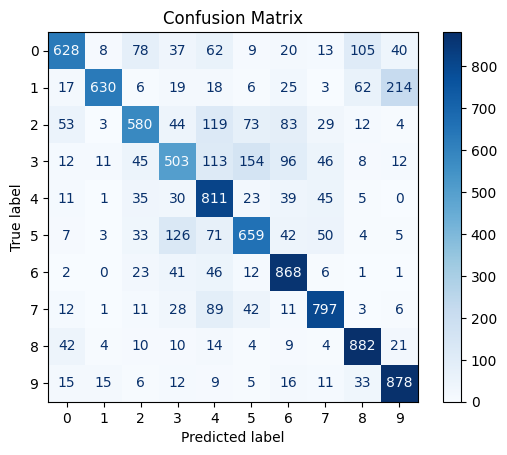

1563/1563 [==============================] - 16s 10ms/step - loss: 0.3701 - accuracy: 0.8707 - val_loss: 0.9695 - val_accuracy: 0.7236
Epoch 7/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,77.22,83.18,63.53,56.66,68.92,62.11,69.3,80.2,81.44,84.03,-
Test Recall,60.0,81.1,61.5,52.3,70.3,68.2,86.7,78.6,86.0,80.0,-
Test F1,67.53,82.13,62.5,54.39,69.6,65.01,77.03,79.39,83.66,81.97,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.66
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,72.47
Test Avg F1,-,-,-,-,-,-,-,-,-,-,72.32
Train Precision,95.56,94.9,93.13,90.65,91.83,90.2,88.57,97.5,97.47,99.38,-
Train Recall,92.94,96.04,90.02,87.02,93.7,93.12,98.54,95.96,97.24,93.58,-
Train F1,94.23,95.47,91.55,88.8,92.75,91.64,93.29,96.72,97.36,96.39,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,93.92


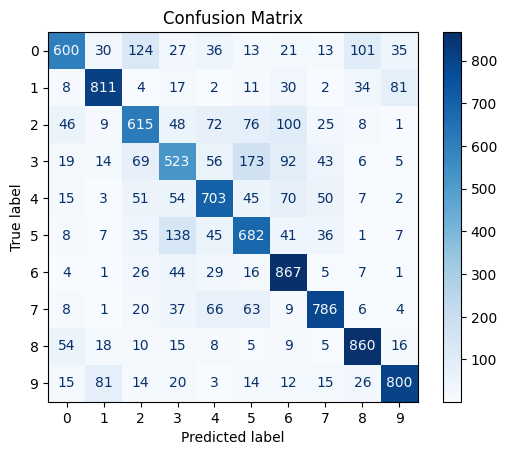

1563/1563 [==============================] - 16s 10ms/step - loss: 0.2789 - accuracy: 0.9015 - val_loss: 1.0199 - val_accuracy: 0.7247
Epoch 8/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,80.61,89.12,63.48,55.62,61.94,67.58,73.15,78.59,73.94,73.44,-
Test Recall,52.8,65.5,63.1,53.9,74.7,61.7,84.2,76.0,90.5,87.1,-
Test F1,63.81,75.5,63.29,54.75,67.72,64.51,78.29,77.28,81.38,79.69,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.75
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,70.95
Test Avg F1,-,-,-,-,-,-,-,-,-,-,70.62
Train Precision,97.34,98.86,92.58,90.14,87.25,93.97,92.69,97.53,92.43,97.33,-
Train Recall,89.32,92.04,92.02,89.44,96.62,88.78,98.16,95.54,98.96,97.7,-
Train F1,93.16,95.33,92.3,89.79,91.7,91.3,95.35,96.52,95.59,97.51,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,94.01


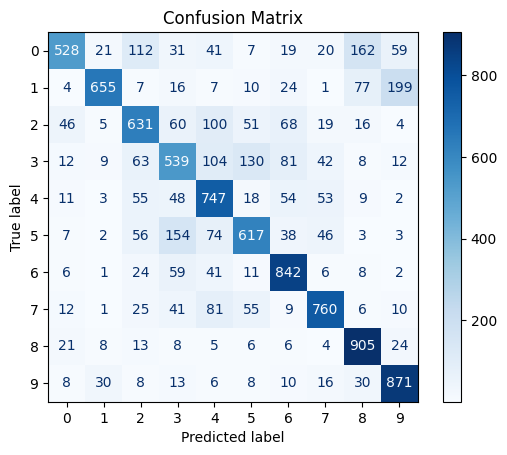

1563/1563 [==============================] - 16s 10ms/step - loss: 0.2133 - accuracy: 0.9246 - val_loss: 1.2479 - val_accuracy: 0.7095
Epoch 9/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,77.88,84.02,67.13,54.81,67.14,61.62,76.9,74.61,83.12,71.59,-
Test Recall,60.2,75.2,57.6,52.4,66.8,67.9,82.9,81.4,84.2,88.7,-
Test F1,67.91,79.37,62.0,53.58,66.97,64.61,79.79,77.86,83.66,79.23,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,71.88
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.73
Test Avg F1,-,-,-,-,-,-,-,-,-,-,71.5
Train Precision,98.3,96.78,97.68,94.45,95.63,92.33,95.02,95.83,98.73,98.02,-
Train Recall,95.84,98.6,91.82,92.22,93.6,96.72,98.16,98.42,97.86,99.22,-
Train F1,97.05,97.68,94.66,93.32,94.6,94.47,96.57,97.11,98.29,98.62,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,96.28


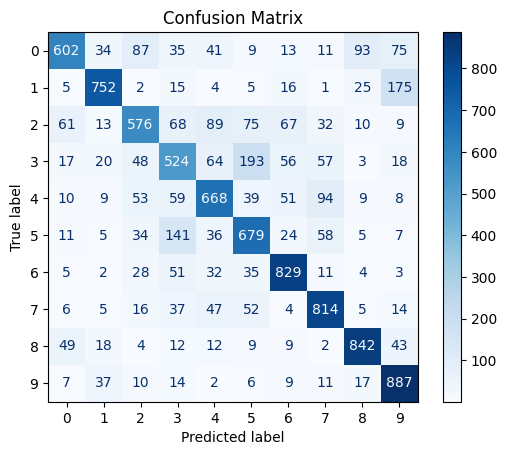

1563/1563 [==============================] - 16s 10ms/step - loss: 0.1665 - accuracy: 0.9412 - val_loss: 1.3639 - val_accuracy: 0.7173
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,72.07,80.62,62.18,62.52,67.29,65.39,72.25,78.2,84.76,76.42,-
Test Recall,72.0,78.6,63.8,39.7,71.6,66.5,85.9,78.9,81.2,86.2,-
Test F1,72.04,79.59,62.98,48.56,69.38,65.94,78.48,78.55,82.94,81.02,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,72.17
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,72.44
Test Avg F1,-,-,-,-,-,-,-,-,-,-,71.95
Train Precision,94.9,96.64,93.95,98.91,94.2,94.7,92.96,97.47,99.26,98.24,-
Train Recall,97.46,98.94,95.94,85.6,96.5,94.72,99.24,97.66,96.1,98.26,-
Train F1,96.16,97.78,94.93,91.78,95.34,94.71,96.0,97.56,97.65,98.25,-
Train Avg Precision,-,-,-,-,-,-,-,-,-,-,96.12


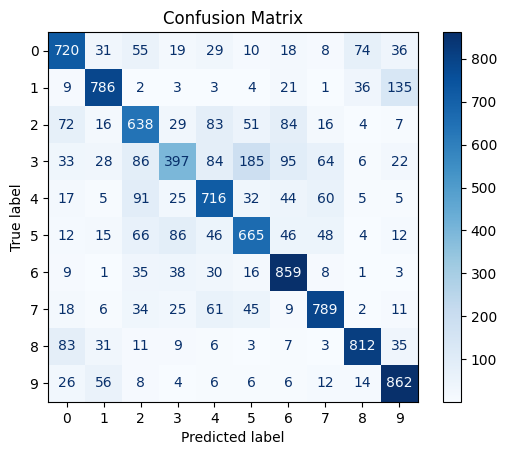

1563/1563 [==============================] - 17s 11ms/step - loss: 0.1468 - accuracy: 0.9485 - val_loss: 1.4632 - val_accuracy: 0.7244


In [26]:
metrics = MetricsCallback(
    x_train = aug_X_norm,
    y_train_true = aug_y,
    x_test = X_test_norm, 
    y_test_true = y_test,
    avg = 'macro',
    show_train = True
)


log_aug = run_model(
    train = aug_train_gen,
    test = test_gen,
    metrics = metrics,
    n_epochs = 10,
    regularization = False,
)

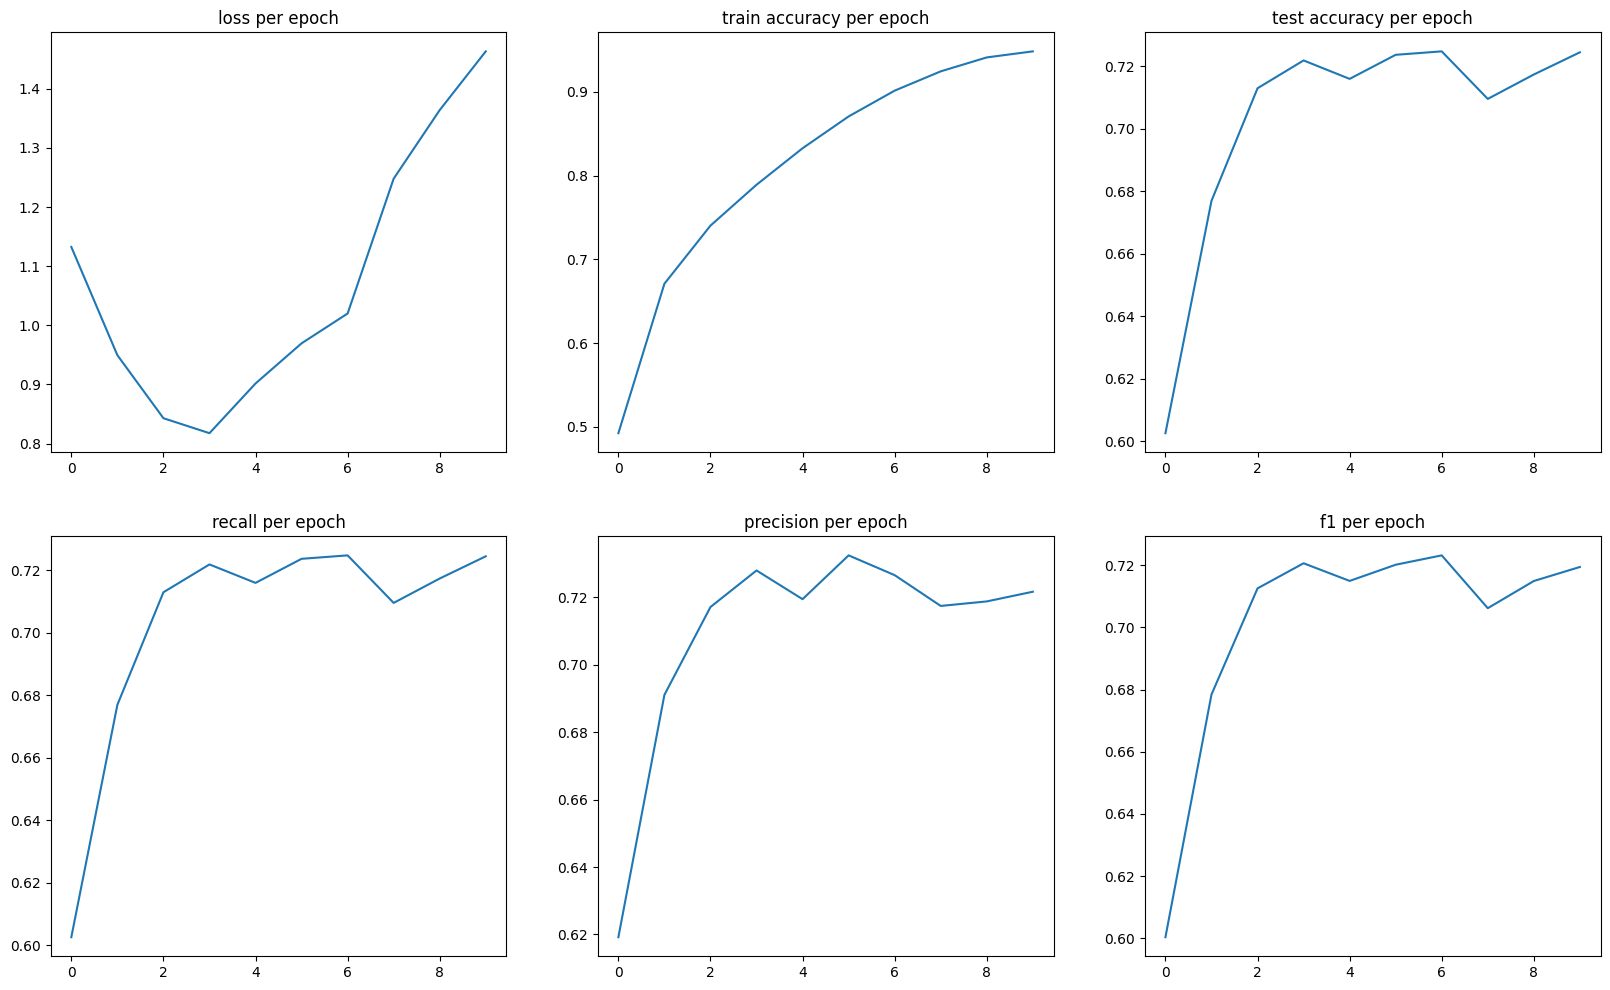

In [27]:
show_plots(log_aug)

## 3.4 Regularization 

`Dropout`:

- Dropout is a regularization technique used in deep learning models to prevent overfitting. It works by randomly setting the outputs of a certain number of neurons to zero during the training phase. This helps to prevent the model from relying too heavily on any one feature, which can lead to overfitting.

- During training, each neuron in the network has a probability of being "dropped out" or ignored with a certain probability p (typically around 0.5). The idea is that the remaining neurons must take on more responsibility for the representation, thereby preventing over-reliance on any one feature.

- Dropout is typically added after the activation layer in a neural network, and before the next layer. This ensures that the next layer receives less structured data, which means it has to learn more general and robust features.

`Batch Normalization`:

- Batch normalization is another technique that's commonly used in deep learning models to improve their performance. It's used to normalize the inputs to each layer, which helps speed up training and improves the stability of the model.

- The basic idea of batch normalization is to standardize the distribution of the input data to each layer, so that it falls within an expected range. This involves subtracting the mean of the batch and dividing by its standard deviation.

- Batch normalization can also help reduce the internal covariate shift problem. This is the phenomenon where the distribution of inputs to each layer changes as the parameters of earlier layers are updated. By normalizing the inputs, we can make training more stable and robust.

- Batch normalization is typically added after the linear transformation and before the activation layer in a neural network. This ensures that the activations going into the next layer are normalized, which helps improve performance and convergence speed.

Epoch 1/10
313/313 [==============================] - 1s 3ms/step 


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,44.03,29.47,22.38,67.59,60.0,67.09,92.79,73.48,62.14,92.46,-
Test Recall,61.9,97.9,56.5,7.3,3.6,21.2,28.3,55.7,62.2,18.4,-
Test F1,51.45,45.3,32.06,13.18,6.79,32.22,43.37,63.37,62.17,30.69,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,61.14
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,41.3
Test Avg F1,-,-,-,-,-,-,-,-,-,-,38.06
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,41.3
Train Accuracy,-,-,-,-,-,-,-,-,-,-,54.59


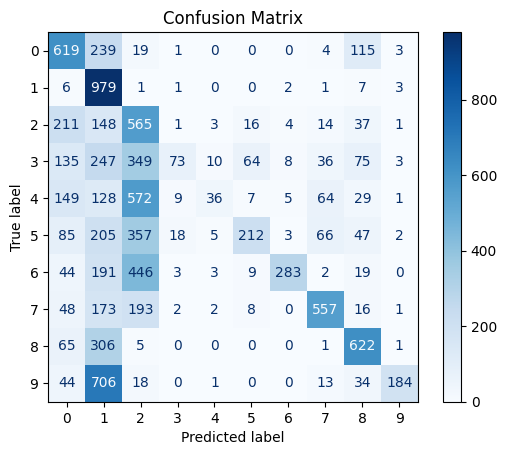

1563/1563 [==============================] - 20s 12ms/step - loss: 1.3190 - accuracy: 0.5459 - val_loss: 2.0490 - val_accuracy: 0.4130
Epoch 2/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,56.76,51.81,37.21,64.69,84.39,50.23,93.6,68.67,91.41,87.6,-
Test Recall,82.3,97.4,75.9,19.6,17.3,66.3,51.2,76.5,46.8,55.1,-
Test F1,67.18,67.64,49.93,30.08,28.71,57.16,66.19,72.37,61.9,67.65,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,68.64
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,58.84
Test Avg F1,-,-,-,-,-,-,-,-,-,-,56.88
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,58.84
Train Accuracy,-,-,-,-,-,-,-,-,-,-,68.74


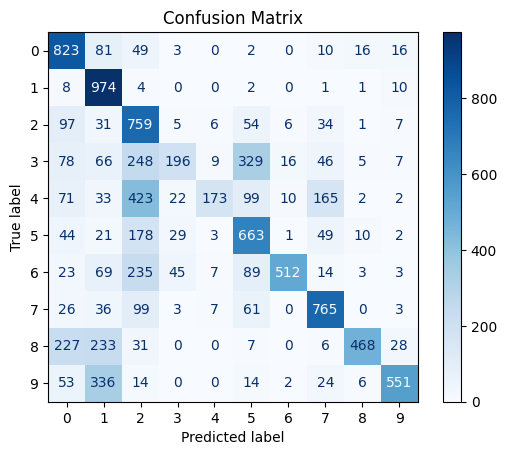

1563/1563 [==============================] - 19s 12ms/step - loss: 0.8899 - accuracy: 0.6874 - val_loss: 1.2182 - val_accuracy: 0.5884
Epoch 3/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,79.19,95.61,64.11,45.76,56.78,73.73,94.57,72.65,84.87,79.0,-
Test Recall,64.7,76.3,60.9,68.5,81.2,55.0,54.0,82.1,83.6,85.0,-
Test F1,71.22,84.87,62.46,54.87,66.83,63.0,68.75,77.09,84.23,81.89,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,74.63
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.13
Test Avg F1,-,-,-,-,-,-,-,-,-,-,71.52
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,71.13
Train Accuracy,-,-,-,-,-,-,-,-,-,-,73.24


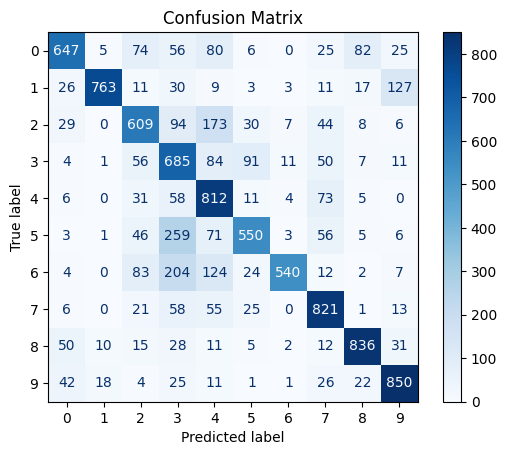

1563/1563 [==============================] - 19s 12ms/step - loss: 0.7664 - accuracy: 0.7324 - val_loss: 0.8332 - val_accuracy: 0.7113
Epoch 4/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,80.51,69.93,65.18,48.19,82.11,56.17,91.85,74.35,85.1,92.37,-
Test Recall,69.8,94.2,64.4,59.8,56.0,76.5,64.2,82.3,81.7,69.0,-
Test F1,74.77,80.27,64.79,53.37,66.59,64.78,75.57,78.12,83.37,78.99,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,74.58
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.79
Test Avg F1,-,-,-,-,-,-,-,-,-,-,72.06
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,71.79
Train Accuracy,-,-,-,-,-,-,-,-,-,-,76.39


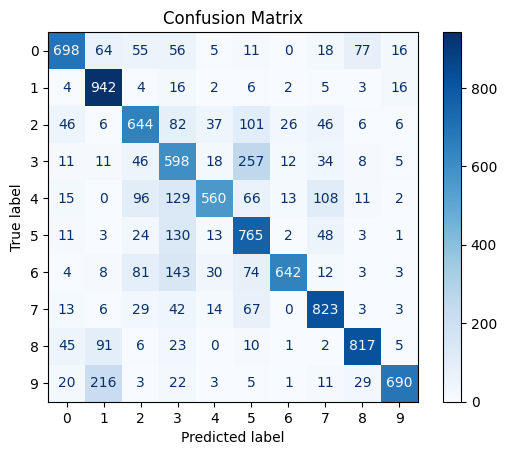

1563/1563 [==============================] - 19s 12ms/step - loss: 0.6819 - accuracy: 0.7639 - val_loss: 0.8122 - val_accuracy: 0.7179
Epoch 5/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,78.25,91.25,79.3,46.68,72.71,58.71,95.58,69.22,93.52,79.05,-
Test Recall,79.5,83.4,52.1,68.3,66.6,72.1,56.2,86.8,77.9,89.4,-
Test F1,78.87,87.15,62.88,55.46,69.52,64.72,70.78,77.02,85.0,83.9,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,76.43
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,73.23
Test Avg F1,-,-,-,-,-,-,-,-,-,-,73.53
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,73.23
Train Accuracy,-,-,-,-,-,-,-,-,-,-,79.08


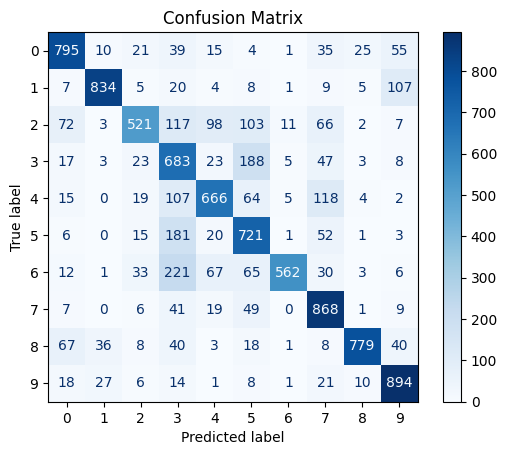

1563/1563 [==============================] - 19s 12ms/step - loss: 0.6051 - accuracy: 0.7908 - val_loss: 0.8065 - val_accuracy: 0.7323
Epoch 6/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,88.19,96.61,73.6,61.93,55.9,83.27,58.24,86.38,67.17,77.89,-
Test Recall,56.0,74.1,53.8,49.3,85.8,45.8,91.9,76.1,94.1,87.7,-
Test F1,68.5,83.87,62.16,54.9,67.69,59.1,71.3,80.91,78.38,82.5,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,74.92
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,71.46
Test Avg F1,-,-,-,-,-,-,-,-,-,-,70.93
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,71.46
Train Accuracy,-,-,-,-,-,-,-,-,-,-,81.38


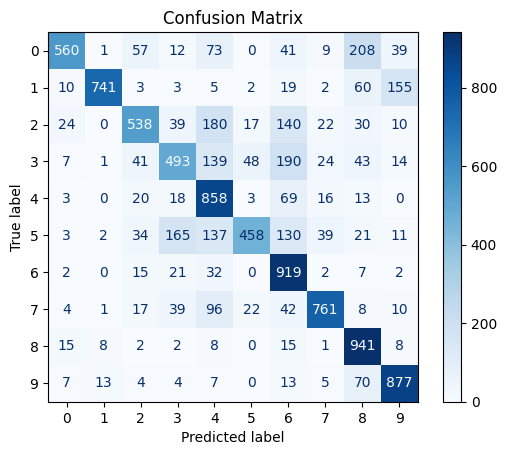

1563/1563 [==============================] - 19s 12ms/step - loss: 0.5370 - accuracy: 0.8138 - val_loss: 0.8573 - val_accuracy: 0.7146
Epoch 7/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,53.96,88.97,65.07,74.48,80.1,62.18,76.71,82.88,90.05,95.73,-
Test Recall,92.6,84.7,70.8,46.7,67.2,75.3,85.3,79.4,71.5,67.3,-
Test F1,68.19,86.78,67.82,57.41,73.08,68.11,80.78,81.1,79.71,79.04,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,77.01
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,74.08
Test Avg F1,-,-,-,-,-,-,-,-,-,-,74.2
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,74.08
Train Accuracy,-,-,-,-,-,-,-,-,-,-,83.19


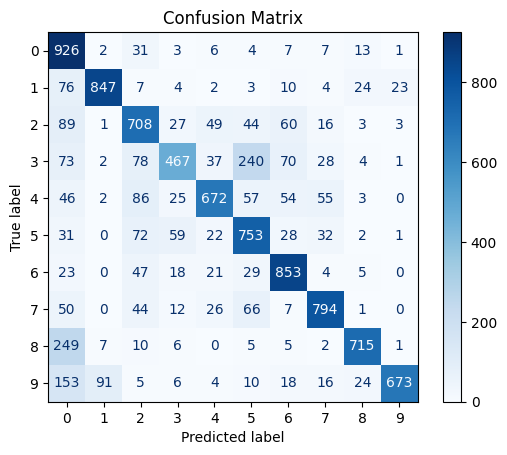

1563/1563 [==============================] - 19s 12ms/step - loss: 0.4823 - accuracy: 0.8319 - val_loss: 0.8152 - val_accuracy: 0.7408
Epoch 8/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,88.12,92.93,73.46,58.52,71.53,59.54,81.2,82.62,86.25,81.33,-
Test Recall,67.5,82.8,55.9,61.5,76.9,79.6,83.8,78.9,87.8,90.6,-
Test F1,76.44,87.57,63.49,59.97,74.12,68.12,82.48,80.72,87.02,85.71,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,77.55
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,76.53
Test Avg F1,-,-,-,-,-,-,-,-,-,-,76.56
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,76.53
Train Accuracy,-,-,-,-,-,-,-,-,-,-,84.71


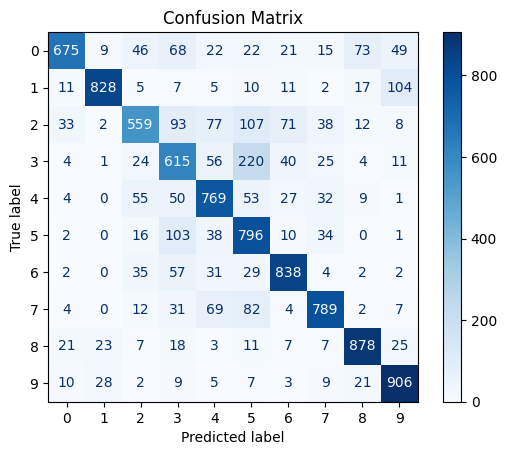

1563/1563 [==============================] - 19s 12ms/step - loss: 0.4328 - accuracy: 0.8471 - val_loss: 0.7188 - val_accuracy: 0.7653
Epoch 9/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,67.2,77.67,70.47,50.57,85.95,82.24,73.72,85.91,69.0,92.63,-
Test Recall,80.1,92.5,56.8,70.9,56.9,47.7,83.6,76.2,92.8,74.2,-
Test F1,73.08,84.44,62.9,59.03,68.47,60.38,78.35,80.76,79.15,82.4,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,75.54
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,73.17
Test Avg F1,-,-,-,-,-,-,-,-,-,-,72.9
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,73.17
Train Accuracy,-,-,-,-,-,-,-,-,-,-,86.51


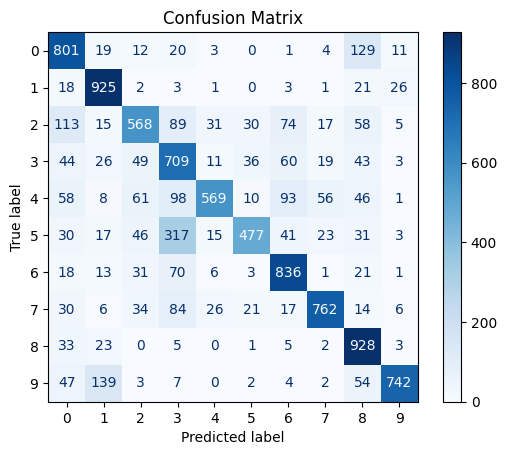

1563/1563 [==============================] - 19s 12ms/step - loss: 0.3877 - accuracy: 0.8651 - val_loss: 0.9058 - val_accuracy: 0.7317
Epoch 10/10
313/313 [==============================] - 1s 3ms/step


,0,1,2,3,4,5,6,7,8,9,All Classes
Test Precision,67.68,83.78,68.51,64.33,77.42,78.92,81.27,80.94,83.35,86.38,-
Test Recall,86.5,90.4,65.5,57.0,72.7,61.4,81.6,84.1,88.1,85.0,-
Test F1,75.94,86.96,66.97,60.45,74.99,69.07,81.44,82.49,85.66,85.69,-
Test Avg Precision,-,-,-,-,-,-,-,-,-,-,77.26
Test Avg Recall,-,-,-,-,-,-,-,-,-,-,77.23
Test Avg F1,-,-,-,-,-,-,-,-,-,-,76.97
-,-,-,-,-,-,-,-,-,-,-,-
Test Accuracy,-,-,-,-,-,-,-,-,-,-,77.23
Train Accuracy,-,-,-,-,-,-,-,-,-,-,87.63


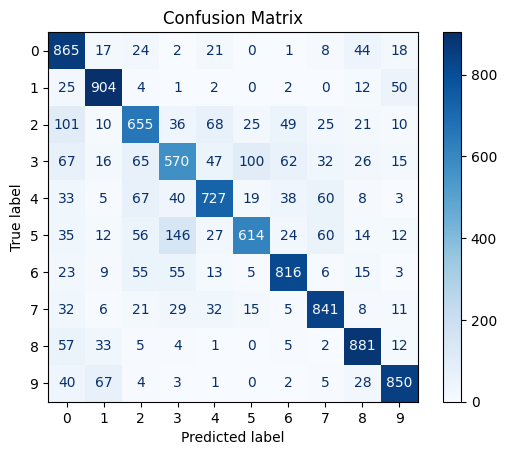

1563/1563 [==============================] - 19s 12ms/step - loss: 0.3501 - accuracy: 0.8763 - val_loss: 0.7581 - val_accuracy: 0.7723


In [29]:
metrics = MetricsCallback(
    x_train = X_train_norm,
    y_train_true = y_train,
    x_test = X_test_norm, 
    y_test_true = y_test,
    avg = 'macro',
    show_train = False
)


log_reg = run_model(
    train = train_gen,
    test = test_gen,
    metrics = metrics,
    n_epochs = 10,
    regularization = True
)

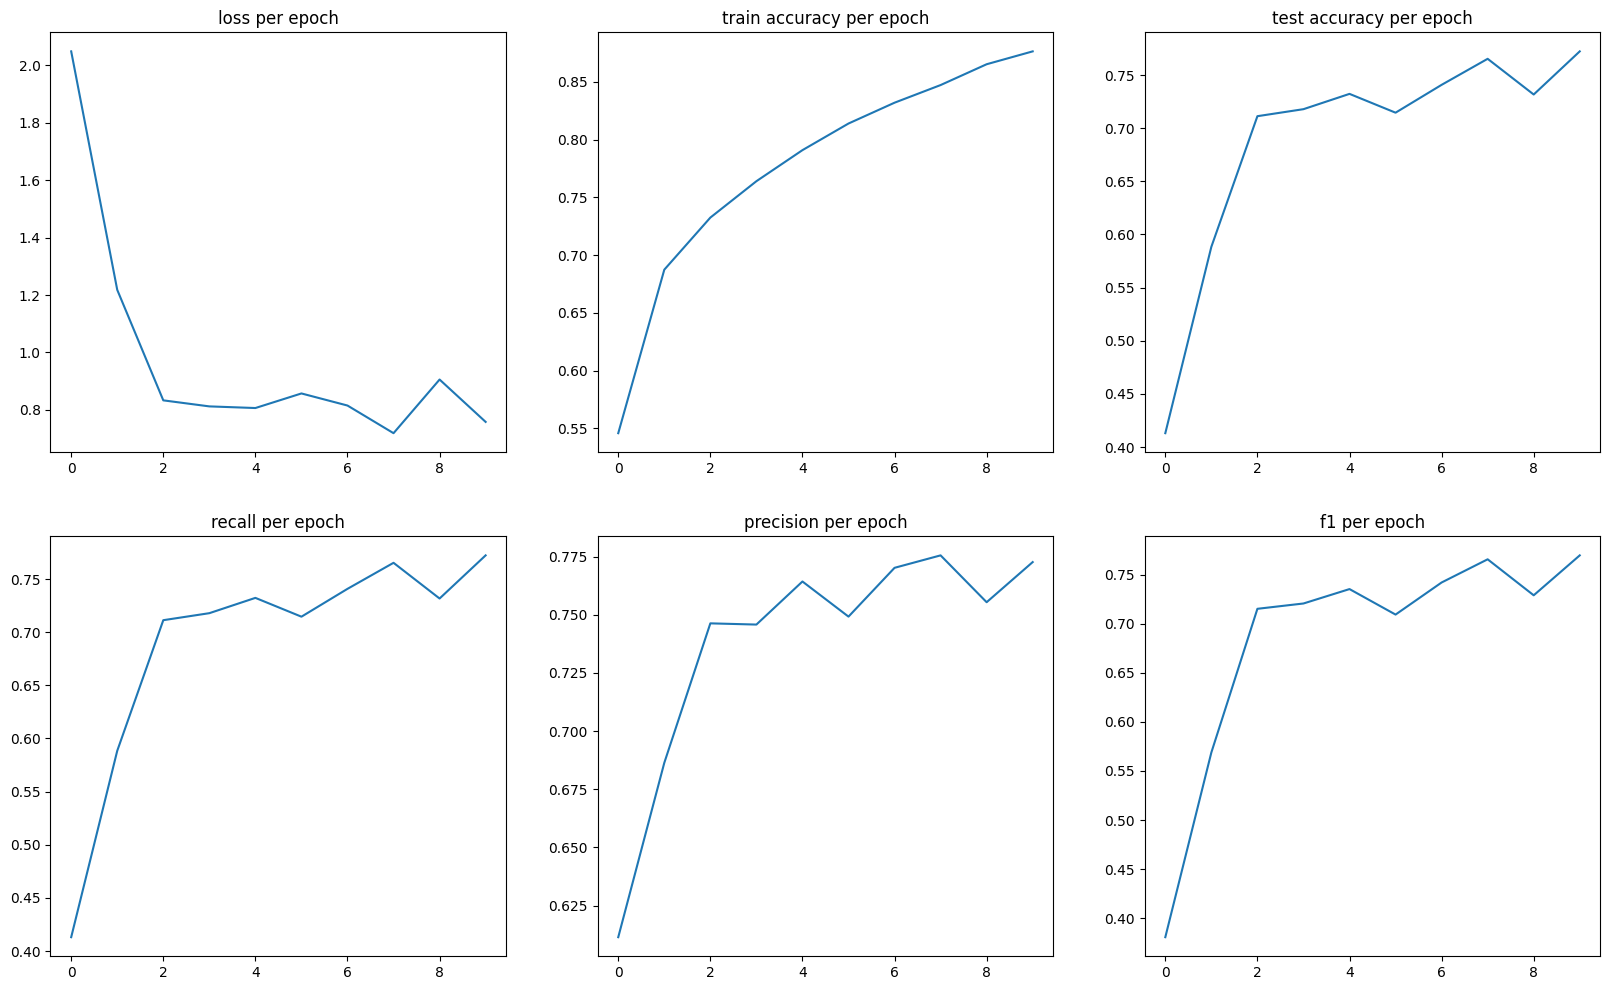

In [30]:
show_plots(log_reg)

## 4 Analyze Effects 


In [60]:
END = 10 - 1
print("effect of regularization:\n")
print("diffrence of train and test accuracy without regularization : ", f"{log.history['accuracy'][END] - log.history['val_accuracy'][END]:.2%}")
print("diffrence of train and test accuracy with regularization : ", f"{log_reg.history['accuracy'][END] - log_reg.history['val_accuracy'][END]:.2%}")

print("diffrence of test f1 due to regularization : ", f"{log_reg.history['f1s'][END] - log.history['f1s'][END]:.2%}")
print("diffrence of test recall due to regularization : ", f"{log_reg.history['recalls'][END] - log.history['recalls'][END]:.2%}")
print("diffrence of test precision due to regularization : ", f"{log_reg.history['precisions'][END] - log.history['precisions'][END]:.2%}")


r = pd.DataFrame(index=['recall unbalanced', 'recall augmented', 'precision unbalanced', 'precision augmented',
'f1 unbalanced', 'f1 augmented'], columns=[0,1])

print("\neffect of augmentation:")
(r.loc['recall unbalanced', 0], r.loc['recall unbalanced', 1]) = (55.1, 70.7)
(r.loc['precision unbalanced', 0], r.loc['precision unbalanced', 1]) = (80.44, 87.28)
(r.loc['f1 unbalanced', 0], r.loc['f1 unbalanced', 1]) = (65.4, 78.12)

(r.loc['recall augmented', 0], r.loc['recall augmented', 1]) = (72.0, 78.6)
(r.loc['precision augmented', 0], r.loc['precision augmented', 1]) = (72.07, 80.62)
(r.loc['f1 augmented', 0], r.loc['f1 augmented', 1]) = (72.04, 79.59)

display(r.astype(str) + '%')

effect of regularization:

diffrence of train and test accuracy without regularization :  21.24%
diffrence of train and test accuracy with regularization :  10.40%
diffrence of test f1 due to regularization :  2.28%
diffrence of test recall due to regularization :  2.48%
diffrence of test precision due to regularization :  2.47%

effect of augmentation:


,0,1
recall unbalanced,55.1%,70.7%
recall augmented,72.0%,78.6%
precision unbalanced,80.44%,87.28%
precision augmented,72.07%,80.62%
f1 unbalanced,65.4%,78.12%
f1 augmented,72.04%,79.59%
